# **Getting and scrapping Data**

In [ ]:
def wg_get_history(internal_id):
    import json
    import requests
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }

    s = requests.Session()
    s.trust_env = False
    df_history = pd.DataFrame()
    i=0
    request_non_null = True
    while request_non_null:
        payload = {'sort[date-seance][path]': 'created',
                        'sort[date-seance][direction]': 'ASC',
                        'filter[instrument][condition][path]': 'symbol.meta.drupal_internal__target_id',
                        'filter[instrument][condition][value]': internal_id,
                        'filter[instrument][condition][operator]': '=',
                        'page[offset]': 250*i,
                        'page[limit]': 250,
                        'filter[filter-date-start-vh-select][condition][path]': 'field_seance_date',
                        'filter[filter-date-start-vh-select][condition][operator]': '>=',
                        'filter[filter-date-start-vh-select][condition][value]': '2021-01-01'
                      }
        content = s.get('https://www.casablanca-bourse.com/api/proxy/fr/api/bourse_data/instrument_history',
                         params=payload).text
        data = json.loads(content)
        df_history = pd.concat([df_history, pd.json_normalize(data['data'])])
        i=i+1
        if len (data['data'])==0 : request_non_null = False




    df_history=df_history[['attributes.created','attributes.coursAjuste','attributes.cumulTitresEchanges',
                          'attributes.cumulVolumeEchange','attributes.highPrice','attributes.lowPrice',
                          'attributes.capitalisation']]
    df_history=df_history.rename(columns={'attributes.created':'created','attributes.coursAjuste':'coursAjuste',
                                          'attributes.cumulTitresEchanges':'cumulTitresEchanges',
                                          'attributes.cumulVolumeEchange':'cumulVolumeEchange',
                                          'attributes.highPrice':'highPrice','attributes.lowPrice':'lowPrice',
                                          'attributes.capitalisation':'capitalisation'})
    df_history['coursAjuste'] = pd.to_numeric(df_history['coursAjuste'], errors='coerce')

     # Convertir la colonne 'created' en format de date
    df_history['created'] = pd.to_datetime(df_history['created'])

    # Regrouper par date et agréger les valeurs
    df_history = df_history.groupby('created').agg({'coursAjuste': 'last',
                                                    'cumulTitresEchanges': 'last',
                                                    'cumulVolumeEchange': 'last',
                                                    'highPrice': 'max',
                                                    'lowPrice': 'min',
                                                    'capitalisation': 'last'}).reset_index()

    # Remplir les dates manquantes et réindexer
    df_history = df_history.set_index('created').asfreq('D').reset_index()

    df_history['return_daily'] = df_history['coursAjuste'].diff() / df_history['coursAjuste'].shift(1)





    return df_history


In [ ]:
def wg_ratios_emetteur(emetteur_url):

    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }
    s = requests.Session()
    #s.trust_env = False
    content = s.get('https://www.casablanca-bourse.com'+emetteur_url+'#emetteur_Ratios').text
    soup = BeautifulSoup(content, "html.parser")
    soup1=soup.find("div", {"id": "emetteur_ratio"})

    df = wg_table_flipped_to_dataframe(soup1)
    return df

In [ ]:
def wg_dividendes_emetteur(emetteur_url):

    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }
    s = requests.Session()
    #s.trust_env = False
    content = s.get('https://www.casablanca-bourse.com'+emetteur_url).text
    soup = BeautifulSoup(content, "html.parser")
    soup1=soup.find("div", {"id": "emetteur_dividendes"})
    data=[]
    soup2=soup1.find("thead")
    cols = soup2.find_all('th')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values
    soup3=soup1.find("tbody")
    rows = soup3.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    headers = data.pop(0)
    df = pd.DataFrame(data, columns=headers)
    return df

In [ ]:
def wg_chiffres_emetteur(emetteur_url):

    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }
    s = requests.Session()
    #s.trust_env = False
    content = s.get('https://www.casablanca-bourse.com'+emetteur_url+'#emetteur_cc').text
    soup = BeautifulSoup(content, "html.parser")
    soup1=soup.find("div", {"id": "emetteur_CC"})
    df = wg_table_flipped_to_dataframe(soup1)
    return df

In [ ]:
def wg_instrument_data(instrument_url):

    import requests
    from bs4 import BeautifulSoup
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }
    s = requests.Session()
    #s.trust_env = False
    content = s.get('https://www.casablanca-bourse.com'+instrument_url+'#instrument_info').text
    soup = BeautifulSoup(content, "html.parser")

    soup1=soup.find("div", {"id": "instrument-info"})
    df = wg_table_no_header_flipped_to_dataframe(soup1)

    soup1=soup.find("div", {"id": "instrument-data"})
    df = pd.concat ([df,wg_table_no_header_flipped_to_dataframe(soup1)], axis=1)

    return df

In [ ]:
def wg_table_flipped_to_dataframe(soup1):
    data=[]
    soup2=soup1.find("thead")
    cols = soup2.find_all('th')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values
    soup3=soup1.find("tbody")
    rows = soup3.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    data_flipped = [list(column) for column in zip(*data)]
    data_flipped[0][0]='Année'
    headers = data_flipped.pop(0)
    return(pd.DataFrame(data_flipped, columns=headers))

In [ ]:
def wg_table_no_header_flipped_to_dataframe(soup1):
    data=[]
    soup1=soup1.find("table")
    rows = soup1.find_all('tr')
    columns = soup1.find_all('th')
    headers = [th.get_text() for th in columns]
    #headers = [th.get_text() for th in rows[0].find_all('td')]
    data = [{ td.get_text() for i, td in enumerate(row.find_all('td'))} for row in rows[0:]]
    for i in range(len(data)):
        data[i]=[headers[i],list(data[i])[0]]
    data_flipped = [list(column) for column in zip(*data)]
    headers = data_flipped.pop(0)
    return(pd.DataFrame(data_flipped, columns=headers))

In [ ]:
def wg_get_MASIR_history():
    import json
    import requests
    import pandas as pd

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
               'Accept': 'application/vnd.api+json',
               'Content-Type': 'application/vnd.api+json'
              }

    s = requests.Session()
    s.trust_env = False
    df_history = pd.DataFrame()
    i=0
    request_non_null = True
    while request_non_null:
        payload = {
                        'fields[bourse_data--index_history]': 'drupal_internal__id,field_seance_date,field_index_value',
                        'sort[date-seance][path]': 'field_seance_date',
                        'sort[date-seance][direction]': 'DESC',
                        'page[offset]': 250*i,
                        'page[limit]': 250,
                        'filter[published]': 1,
                        'filter[filter-date-start-vh-select][condition][path]': 'field_seance_date',
                        'filter[filter-date-start-vh-select][condition][operator]': '>=',
                        'filter[filter-date-start-vh-select][condition][value]': '2021-01-01',
                        'filter[index-historique-code][condition][path]': 'field_index_code.tid',
                        'filter[index-historique-code][condition][operator]': '=',
                        'filter[index-historique-code][condition][value]': '512340'
                      }
        content = s.get('https://www.casablanca-bourse.com/api/proxy/fr/api/bourse_data/index_history',
                         params=payload).text
        data = json.loads(content)
        df_history = pd.concat([df_history, pd.json_normalize(data['data'])])
        i=i+1
        if len (data['data'])==0 : request_non_null = False
    df_history=df_history[['attributes.field_seance_date','attributes.field_index_value']]
    df_history=df_history.rename(columns={'attributes.field_seance_date':'field_seance_date',
                                          'attributes.field_index_value':'field_index_value'})
    return df_history

In [ ]:
import json
import requests
import pandas as pd

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 Edg/121.0.0.0',
           'Accept': 'application/vnd.api+json',
           'Content-Type': 'application/vnd.api+json'
          }

s = requests.Session()
s.trust_env = False

df_instruments = pd.DataFrame()
i=0
request_non_null = True
while request_non_null:
    payload = {'fields[emetteur]': 'name',
               'fields[sous_secteur]': 'name',
               'include': 'codeSousSecteur,codeSociete',
               'filter[radie]': 0,
               'page[offset]': 50*i,
               'sort[emetteur][path]': 'codeSociete.name',
               'sort[emetteur][direction]': 'ASC'
              }
    content = s.get('https://www.casablanca-bourse.com/api/proxy/fr/api/bourse_data/instrument',
                     params=payload).text
    data = json.loads(content)
    df_instruments = pd.concat([df_instruments, pd.json_normalize(data['data'])], ignore_index=True)
    i=i+1
    if len (data['data'])==0 : request_non_null = False
df_instruments = df_instruments[(df_instruments['attributes.dateEcheance'].isna()) &
                                (df_instruments['attributes.dateJouissance'].isna()) &
                                (df_instruments['attributes.valeurNominale']!='0.0000000000')]
df_instruments=df_instruments[['attributes.libelleFR','attributes.symbol','attributes.codeISIN','attributes.instrument_url',
                               'attributes.drupal_internal__id','attributes.emetteur_url']]
df_instruments=df_instruments.rename(columns={'attributes.libelleFR':'libelleFR', 'attributes.symbol':'symbol',
                                              'attributes.codeISIN': 'codeISIN','attributes.instrument_url':'instrument_url',
                                              'attributes.drupal_internal__id':'drupal_internal__id','attributes.emetteur_url':'emetteur_url'})

df_instruments[['Secteur','Capitalisation']] = df_instruments.apply(lambda x: wg_instrument_data(x['instrument_url'])[['Secteur','Capitalisation']].loc[0],axis=1, result_type='expand')
df_instruments[['PBR','PER']] = df_instruments.apply(lambda x: wg_ratios_emetteur(x['emetteur_url'])[['PBR','PER']].loc[0],axis=1, result_type='expand')

In [ ]:
d_MASIR = wg_get_MASIR_history()
d_MASIR

field_seance_date field_index_value
0          2024-06-28  41697.3420000000
1          2024-06-27  41750.0803000000
2          2024-06-26  41850.7920000000
3          2024-06-25  42014.7922000000
4          2024-06-24  41118.3468000000
..                ...               ...
247        2021-07-02  35401.1500000000
248        2021-07-01  35380.5500000000
249        2021-06-30  35352.0500000000
0          2021-06-29  35360.0500000000
1          2021-06-28  35521.0600000000

[752 rows x 2 columns]

In [ ]:
df_instruments

libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur     Capitalisation    PBR     PER  
0                               Assurances   1 248 000 000,00  21,85   20,00  
1    Bâtiment et Matériaux de Construction      92 405 500,00   2,22   21,91  
2                           Pétrole et Gaz  13 406 250 000,00   4,63   28,56  
3                               Assurances   1 365 000 000,00   8,73   20,16  
4                                    Santé   8 752 668 970,00   4,41   31,76  
..                                     ...                ...    ...     ...  
116  Bâtiment et Matériaux de Construction   9 808 353 500,00   3,98   16,23  
117                         Pétrole et Gaz  12 355 840 000,00   4,49  206,84  
118          Agroalimentaire et Production   2 020 256 760,00   1,49       -  
119                             Assurances  13 650 000 000,00   1,52   20,88  
120   Sociétés de Portefeuilles / Holdings      43 169 900,64   0,80       -  

[76 rows x 10 columns]

# **Cleaning and preparing Data**

In [ ]:
df = df_instruments.copy()

df['PBR'] = df['PBR'].str.replace(',', '.')

df['PBR'] = pd.to_numeric(df['PBR'], errors='coerce', downcast='integer')

df['BTM'] = 1 / df['PBR']

df



libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur     Capitalisation    PBR     PER  \
0                               Assurances   1 248 000 000,00  21.85   20,00   
1    Bâtiment et Matériaux de Construction      92 405 500,00   2.22   21,91   
2                           Pétrole et Gaz  13 406 250 000,00   4.63   28,56   
3                               Assurances   1 365 000 000,00   8.73   20,16   
4                                    Santé   8 752 668 970,00   4.41   31,76   
..                                     ...                ...    ...     ...   
116  Bâtiment et Matériaux de Construction   9 808 353 500,00   3.98   16,23   
117                         Pétrole et Gaz  12 355 840 000,00   4.49  206,84   
118          Agroalimentaire et Production   2 020 256 760,00   1.49       -   
119                             Assurances  13 650 000 000,00   1.52   20,88   
120   Sociétés de Portefeuilles / Holdings      43 169 900,64   0.80       -   

          BTM  
0    0.045767  
1    0.450450  
2    0.215983  
3    0.114548  
4    0.226757  
..        ...  
116  0.251256  
117  0.222717  
118  0.671141  
119  0.657895  
120  1.250000  

[76 rows x 11 columns]

In [ ]:
a = df['Capitalisation'][0]
a

'1 227 000 000,00'

In [ ]:
df['Capitalisation'] = df['Capitalisation'].str.replace(',', '.')
df

libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur     Capitalisation    PBR     PER  \
0                               Assurances   1 248 000 000.00  21.85   20,00   
1    Bâtiment et Matériaux de Construction      92 405 500.00   2.22   21,91   
2                           Pétrole et Gaz  13 406 250 000.00   4.63   28,56   
3                               Assurances   1 365 000 000.00   8.73   20,16   
4                                    Santé   8 752 668 970.00   4.41   31,76   
..                                     ...                ...    ...     ...   
116  Bâtiment et Matériaux de Construction   9 808 353 500.00   3.98   16,23   
117                         Pétrole et Gaz  12 355 840 000.00   4.49  206,84   
118          Agroalimentaire et Production   2 020 256 760.00   1.49       -   
119                             Assurances  13 650 000 000.00   1.52   20,88   
120   Sociétés de Portefeuilles / Holdings      43 169 900.64   0.80       -   

          BTM  
0    0.045767  
1    0.450450  
2    0.215983  
3    0.114548  
4    0.226757  
..        ...  
116  0.251256  
117  0.222717  
118  0.671141  
119  0.657895  
120  1.250000  

[76 rows x 11 columns]

In [ ]:
df['Capitalisation'] = df['Capitalisation'].str.replace(' ', '')
df['Capitalisation'] = pd.to_numeric(df['Capitalisation'])
df


libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur  Capitalisation    PBR     PER  \
0                               Assurances    1.248000e+09  21.85   20,00   
1    Bâtiment et Matériaux de Construction    9.240550e+07   2.22   21,91   
2                           Pétrole et Gaz    1.340625e+10   4.63   28,56   
3                               Assurances    1.365000e+09   8.73   20,16   
4                                    Santé    8.752669e+09   4.41   31,76   
..                                     ...             ...    ...     ...   
116  Bâtiment et Matériaux de Construction    9.808354e+09   3.98   16,23   
117                         Pétrole et Gaz    1.235584e+10   4.49  206,84   
118          Agroalimentaire et Production    2.020257e+09   1.49       -   
119                             Assurances    1.365000e+10   1.52   20,88   
120   Sociétés de Portefeuilles / Holdings    4.316990e+07   0.80       -   

          BTM  
0    0.045767  
1    0.450450  
2    0.215983  
3    0.114548  
4    0.226757  
..        ...  
116  0.251256  
117  0.222717  
118  0.671141  
119  0.657895  
120  1.250000  

[76 rows x 11 columns]

In [ ]:
median_capitalization = df['Capitalisation'].median()

df['Category'] = df['Capitalisation'].apply(lambda x: 'S' if x <= median_capitalization else 'B')

df

libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur  Capitalisation    PBR     PER  \
0                               Assurances    1.248000e+09  21.85   20,00   
1    Bâtiment et Matériaux de Construction    9.240550e+07   2.22   21,91   
2                           Pétrole et Gaz    1.340625e+10   4.63   28,56   
3                               Assurances    1.365000e+09   8.73   20,16   
4                                    Santé    8.752669e+09   4.41   31,76   
..                                     ...             ...    ...     ...   
116  Bâtiment et Matériaux de Construction    9.808354e+09   3.98   16,23   
117                         Pétrole et Gaz    1.235584e+10   4.49  206,84   
118          Agroalimentaire et Production    2.020257e+09   1.49       -   
119                             Assurances    1.365000e+10   1.52   20,88   
120   Sociétés de Portefeuilles / Holdings    4.316990e+07   0.80       -   

          BTM Category  
0    0.045767        S  
1    0.450450        S  
2    0.215983        B  
3    0.114548        S  
4    0.226757        B  
..        ...      ...  
116  0.251256        B  
117  0.222717        B  
118  0.671141        S  
119  0.657895        B  
120  1.250000        S  

[76 rows x 12 columns]

In [ ]:
median_btm = df['BTM'].median()

df['BTM_Category'] = df['BTM'].apply(lambda x: 'H' if x > median_btm else 'L')

df

libelleFR symbol      codeISIN  \
0                             AFMA    AFM  MA0000012296   
1              AFRIC INDUSTRIES SA    AFI  MA0000012114   
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
3                             AGMA    AGM  MA0000010944   
4                          AKDITAL    AKT  MA0000012585   
..                             ...    ...           ...   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   
118                         UNIMER    UMR  MA0000012023   
119                 WAFA ASSURANCE    WAA  MA0000010928   
120                   ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
2    /fr/live-market/instruments/GAZ                  498   
3    /fr/live-market/instruments/AGM                  491   
4    /fr/live-market/instruments/AKT               305583   
..                               ...                  ...   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   
118  /fr/live-market/instruments/UMR                  503   
119  /fr/live-market/instruments/WAA                  488   
120  /fr/live-market/instruments/ZDJ                  485   

                            emetteur_url  \
0    /fr/live-market/emetteurs/AFM151215   
1    /fr/live-market/emetteurs/AFI050112   
2    /fr/live-market/emetteurs/GAZ030599   
3    /fr/live-market/emetteurs/AGM091198   
4          /fr/live-market/emetteurs/AKT   
..                                   ...   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   
118  /fr/live-market/emetteurs/UMR290301   
119  /fr/live-market/emetteurs/WAA130798   
120  /fr/live-market/emetteurs/ZDJ200655   

                                   Secteur  Capitalisation    PBR     PER  \
0                               Assurances    1.248000e+09  21.85   20,00   
1    Bâtiment et Matériaux de Construction    9.240550e+07   2.22   21,91   
2                           Pétrole et Gaz    1.340625e+10   4.63   28,56   
3                               Assurances    1.365000e+09   8.73   20,16   
4                                    Santé    8.752669e+09   4.41   31,76   
..                                     ...             ...    ...     ...   
116  Bâtiment et Matériaux de Construction    9.808354e+09   3.98   16,23   
117                         Pétrole et Gaz    1.235584e+10   4.49  206,84   
118          Agroalimentaire et Production    2.020257e+09   1.49       -   
119                             Assurances    1.365000e+10   1.52   20,88   
120   Sociétés de Portefeuilles / Holdings    4.316990e+07   0.80       -   

          BTM Category BTM_Category  
0    0.045767        S            L  
1    0.450450        S            L  
2    0.215983        B            L  
3    0.114548        S            L  
4    0.226757        B            L  
..        ...      ...          ...  
116  0.251256        B            L  
117  0.222717        B            L  
118  0.671141        S            H  
119  0.657895        B            H  
120  1.250000        S            H  

[76 rows x 13 columns]

In [ ]:
df_SH = df[(df['Category'] == 'S') & (df['BTM_Category'] == 'H')]
df_BH = df[(df['Category'] == 'B') & (df['BTM_Category'] == 'H')]
df_SL = df[(df['Category'] == 'S') & (df['BTM_Category'] == 'L')]
df_BL = df[(df['Category'] == 'B') & (df['BTM_Category'] == 'L')]



In [ ]:
print (df_SH.shape[0])
print (df_BH.shape[0])
print (df_SL.shape[0])
print (df_BL.shape[0])

18
16
20
22


In [ ]:
df_SH

libelleFR symbol      codeISIN  \
34             CARTIER SAADA    CRS  MA0000011868   
58        DISTY TECHNOLOGIES    DYT  MA0000012536   
59                    DISWAY    DWY  MA0000011637   
62                    ENNAKL    NKL  MA0000011942   
63                     EQDOM    EQD  MA0000010357   
65           FENIE BROSSETTE    FBR  MA0000011587   
69          IMMORENTE INVEST    IMO  MA0000012387   
70                   INVOLYS    INV  MA0000011579   
72           JET CONTRACTORS    JET  MA0000012080   
79           MAGHREB OXYGENE    MOX  MA0000010985   
80                MAGHREBAIL    MAB  MA0000011215   
82             MAROC LEASING    MLE  MA0000010035   
96             REBAB COMPANY    REB  MA0000010993   
101                    SAMIR    SAM  MA0000010803   
106                     SNEP    SNP  MA0000011728   
112  REALISATIONS MECANIQUES    SRM  MA0000011595   
118                   UNIMER    UMR  MA0000012023   
120             ZELLIDJA S.A    ZDJ  MA0000010571   

                      instrument_url  drupal_internal__id  \
34   /fr/live-market/instruments/CRS                  521   
58   /fr/live-market/instruments/DYT                  451   
59   /fr/live-market/instruments/DWY                  536   
62   /fr/live-market/instruments/NKL                  381   
63   /fr/live-market/instruments/EQD                  430   
65   /fr/live-market/instruments/FBR                  532   
69   /fr/live-market/instruments/IMO                  388   
70   /fr/live-market/instruments/INV                  534   
72   /fr/live-market/instruments/JET                  384   
79   /fr/live-market/instruments/MOX                  499   
80   /fr/live-market/instruments/MAB                  400   
82   /fr/live-market/instruments/MLE                  434   
96   /fr/live-market/instruments/REB                  482   
101  /fr/live-market/instruments/SAM                  492   
106  /fr/live-market/instruments/SNP                  367   
112  /fr/live-market/instruments/SRM                  533   
118  /fr/live-market/instruments/UMR                  503   
120  /fr/live-market/instruments/ZDJ                  485   

                             emetteur_url  \
34    /fr/live-market/emetteurs/CRS210606   
58          /fr/live-market/emetteurs/DYT   
59    /fr/live-market/emetteurs/MAR280207   
62   /fr/live-market/emetteurs/NAKL130710   
63    /fr/live-market/emetteurs/EQD210978   
65    /fr/live-market/emetteurs/FBR041206   
69    /fr/live-market/emetteurs/IMO110518   
70    /fr/live-market/emetteurs/INV141206   
72   /fr/live-market/emetteurs/JALU091211   
79    /fr/live-market/emetteurs/MOX170699   
80    /fr/live-market/emetteurs/MAB100797   
82    /fr/live-market/emetteurs/MLE270297   
96    /fr/live-market/emetteurs/REB121184   
101   /fr/live-market/emetteurs/SAM190396   
106   /fr/live-market/emetteurs/SNP071107   
112   /fr/live-market/emetteurs/SRM121206   
118   /fr/live-market/emetteurs/UMR290301   
120   /fr/live-market/emetteurs/ZDJ200655   

                                               Secteur  Capitalisation   PBR  \
34                       Agroalimentaire et Production    1.663214e+08  0.99   
58      Matériels, Logiciels et Services Informatiques    2.580114e+08  1.12   
59      Matériels, Logiciels et Services Informatiques    1.314376e+09  1.83   
62                                       Distributeurs    1.056000e+09  1.14   
63   Sociétés de financement et Autres Activités Fi...    1.767124e+09  1.12   
65                                       Distributeurs    1.411643e+08  1.03   
69                    Sociétés de placement immobilier    8.340482e+08  1.23   
70      Matériels, Logiciels et Services Informatiques    3.215580e+07  0.44   
72               Bâtiment et Matériaux de Construction    1.741975e+09  0.72   
79                                              Chimie    1.657500e+08  0.63   
80   Sociétés de financement et Autres Activités Fi...    1.345425e+09  1.16   
82   Sociétés de financement et Aut

In [ ]:
df_history_0= wg_get_history(df_SH['drupal_internal__id'][34])


df_history_0

created  coursAjuste cumulTitresEchanges cumulVolumeEchange  \
0    2021-06-28        27.00       51.0000000000    1377.0000000000   
1    2021-06-29        26.60       24.0000000000     638.4000000000   
2    2021-06-30        26.60                None               None   
3    2021-07-01        26.50       49.0000000000    1300.5000000000   
4    2021-07-02        27.55        2.0000000000      55.1000000000   
...         ...          ...                 ...                ...   
1092 2024-06-24        31.63        9.0000000000     284.6700000000   
1093 2024-06-25        31.63       12.0000000000     379.5600000000   
1094 2024-06-26        31.63        1.0000000000      31.6300000000   
1095 2024-06-27        31.60      252.0000000000    7951.7700000000   
1096 2024-06-28        31.59      150.0000000000    4544.5000000000   

          highPrice       lowPrice        capitalisation  return_daily  
0     27.0000000000  27.0000000000  142155000.0000000000           NaN  
1     26.6000000000  26.6000000000  140049000.0000000000     -0.014815  
2               NaN            NaN  140049000.0000000000      0.000000  
3     27.0000000000  26.5000000000  139522500.0000000000     -0.003759  
4     27.5500000000  27.5500000000  145050750.0000000000      0.039623  
...             ...            ...                   ...           ...  
1092  31.6300000000  31.6300000000  166531950.0000000000           NaN  
1093  31.6300000000  31.6300000000  166531950.0000000000      0.000000  
1094  31.6300000000  31.6300000000  166531950.0000000000      0.000000  
1095  31.6000000000  31.0000000000  166374000.0000000000     -0.000948  
1096  31.5900000000  29.6500000000  166321350.0000000000     -0.000316  

[1097 rows x 8 columns]

In [ ]:
df_history_0['created'][0]

Timestamp('2021-06-28 00:00:00')

In [ ]:
df_BH

libelleFR symbol      codeISIN  \
5               ALLIANCES    ADI  MA0000011819   
7          ARADEI CAPITAL    ARD  MA0000012460   
13      ATTIJARIWAFA BANK    ATW  MA0000012445   
25         BANK OF AFRICA    BOA  MA0000012437   
30                    BCP    BCP  MA0000011884   
31                   BMCI    BCI  MA0000010811   
37                    CDM    CDM  MA0000010381   
40                    CIH    CIH  MA0000011454   
55          DELTA HOLDING    DHO  MA0000011850   
60      DOUJA PROM ADDOHA    ADH  MA0000011512   
86           MUTANDIS SCA    MUT  MA0000012395   
97   RESIDENCES DAR SAADA    RDS  MA0000012239   
102          SANLAM MAROC    SAH  MA0000012007   
105                   SMI    SMI  MA0000010068   
110               SONASID    SID  MA0000010019   
119        WAFA ASSURANCE    WAA  MA0000010928   

                      instrument_url  drupal_internal__id  \
5    /fr/live-market/instruments/ADI                  379   
7    /fr/live-market/instruments/ARD                  437   
13   /fr/live-market/instruments/ATW                  511   
25   /fr/live-market/instruments/BOA                  373   
30   /fr/live-market/instruments/BCP                  509   
31   /fr/live-market/instruments/BCI                  476   
37   /fr/live-market/instruments/CDM                  458   
40   /fr/live-market/instruments/CIH                  449   
55   /fr/live-market/instruments/DHO                  371   
60   /fr/live-market/instruments/ADH                  525   
86   /fr/live-market/instruments/MUT                  423   
97   /fr/live-market/instruments/RDS                  389   
102  /fr/live-market/instruments/SAH                  382   
105  /fr/live-market/instruments/SMI                  398   
110  /fr/live-market/instruments/SID                  394   
119  /fr/live-market/instruments/WAA                  488   

                             emetteur_url  \
5     /fr/live-market/emetteurs/ADI170708   
7           /fr/live-market/emetteurs/ARD   
13    /fr/live-market/emetteurs/BCM130843   
25    /fr/live-market/emetteurs/BCE260675   
30    /fr/live-market/emetteurs/BCP060704   
31    /fr/live-market/emetteurs/BCI280272   
37    /fr/live-market/emetteurs/CDM030576   
40    /fr/live-market/emetteurs/CIH230667   
55    /fr/live-market/emetteurs/DHO150508   
60    /fr/live-market/emetteurs/ADH060706   
86    /fr/live-market/emetteurs/MUT181218   
97    /fr/live-market/emetteurs/RDS250612   
102  /fr/live-market/emetteurs/CNIA221110   
105   /fr/live-market/emetteurs/SMI180697   
110   /fr/live-market/emetteurs/SID020796   
119   /fr/live-market/emetteurs/WAA130798   

                                     Secteur  Capitalisation   PBR    PER  \
5    Participation et promotion immobilières    5.431333e+09  0.74  10,68   
7           Sociétés de placement immobilier    5.867398e+09  1.09  17,76   
13                                   Banques    1.109051e+11  1.36  13,90   
25                                   Banques    4.121648e+10  1.13  14,33   
30                                   Banques    6.018049e+10  1.02  16,09   
31                                   Banques    8.033968e+09  0.99  41,88   
37                                   Banques    1.033715e+10  1.22  17,24   
40                                   Banques    1.184168e+10  1.42  15,10   
55      Sociétés de Portefeuilles / Holdings    4.292400e+09  1.23  14,24   
60   Participation et promotion immobilières    1.218925e+10  0.58  33,02   
86             Agroalimentaire et Production    2.448074e+09  1.64  20,51   
97   Participation et promotion immobilières    2.071810e+09  0.14      -   
102                               Assurances    8.027904e+09  0.98   9,56   
105                                    Mines    3.865962e+09  1.62  12,92   
110    Bâtiment et Matériaux de Construction    3.248700e+09  1.42  39,55   
119                               Assurances    1.365000e+10  1.52  20,88   

          BTM Category BTM_Category  
5    1.351351

In [ ]:
df_SL

libelleFR symbol      codeISIN  \
0                       AFMA    AFM  MA0000012296   
1        AFRIC INDUSTRIES SA    AFI  MA0000012114   
3                       AGMA    AGM  MA0000010944   
6         ALUMINIUM DU MAROC    ALM  MA0000010936   
21                AUTO NEJMA    NEJ  MA0000011009   
24                    BALIMA    BAL  MA0000011991   
44                  COLORADO    COL  MA0000011934   
51                       CTM    CTM  MA0000010340   
53             DARI COUSPATE    DRI  MA0000011421   
54   DELATTRE LEVIVIER MAROC    DLM  MA0000012551   
56                DIAC SALAF    DIS  MA0000010639   
68              IB MAROC.COM    IBC  MA0000011132   
78                 M2M Group    M2M  MA0000011678   
84                 MED PAPER    MDP  MA0000012593   
85                 MICRODATA    MIC  MA0000012163   
94           PROMOPHARM S.A.    PRO  MA0000011660   
99             S.M MONETIQUE    S2M  MA0000012106   
100                  SALAFIN    SLF  MA0000011744   
113     STOKVIS NORD AFRIQUE    SNA  MA0000011843   
114          STROC INDUSTRIE    STR  MA0000012056   

                      instrument_url  drupal_internal__id  \
0    /fr/live-market/instruments/AFM                  391   
1    /fr/live-market/instruments/AFI                  385   
3    /fr/live-market/instruments/AGM                  491   
6    /fr/live-market/instruments/ALM                  490   
21   /fr/live-market/instruments/NEJ                  494   
24   /fr/live-market/instruments/BAL                  455   
44   /fr/live-market/instruments/COL                  530   
51   /fr/live-market/instruments/CTM                  428   
53   /fr/live-market/instruments/DRI                  512   
54   /fr/live-market/instruments/DLM                  370   
56   /fr/live-market/instruments/DIS                  466   
68   /fr/live-market/instruments/IBC                  504   
78   /fr/live-market/instruments/M2M                  360   
84   /fr/live-market/instruments/MDP                  489   
85   /fr/live-market/instruments/MIC                  368   
94   /fr/live-market/instruments/PRO                  541   
99   /fr/live-market/instruments/S2M                  386   
100  /fr/live-market/instruments/SLF                  369   
113  /fr/live-market/instruments/SNA                  366   
114  /fr/live-market/instruments/STR                  383   

                             emetteur_url  \
0     /fr/live-market/emetteurs/AFM151215   
1     /fr/live-market/emetteurs/AFI050112   
3     /fr/live-market/emetteurs/AGM091198   
6     /fr/live-market/emetteurs/ALM271098   
21    /fr/live-market/emetteurs/NEJ030599   
24    /fr/live-market/emetteurs/BAL050746   
44    /fr/live-market/emetteurs/COL271006   
51    /fr/live-market/emetteurs/CTM030693   
53   /fr/live-market/emetteurs/DARI110705   
54    /fr/live-market/emetteurs/DLM290408   
56    /fr/live-market/emetteurs/DIS010662   
68   /fr/live-market/emetteurs/IBMC100701   
78    /fr/live-market/emetteurs/M2M040707   
84    /fr/live-market/emetteurs/PDT280798   
85    /fr/live-market/emetteurs/MIC311207   
94    /fr/live-market/emetteurs/PRO150607   
99    /fr/live-market/emetteurs/S2M271211   
100   /fr/live-market/emetteurs/SLF171207   
113   /fr/live-market/emetteurs/SNA031207   
114   /fr/live-market/emetteurs/STR300611   

                                               Secteur  Capitalisation    PBR  \
0                                           Assurances    1.248000e+09  21.85   
1                Bâtiment et Matériaux de Construction    9.240550e+07   2.22   
3                                           Assurances    1.365000e+09   8.73   
6                Bâtiment et Matériaux de Construction    7.031246e+08   2.38   
21                                       Distributeurs    1.996388e+09   2.20   
24                    Sociétés de placement immobilier    4.098400e+08   2.60   
44               Bâtiment et Matériaux de Construction    8.537499e+08   2.30   
51                           

In [ ]:
df_BL

libelleFR symbol      codeISIN  \
2                     AFRIQUIA GAZ    GAZ  MA0000010951   
4                          AKDITAL    AKT  MA0000012585   
8                     ATLANTASANAD    ATL  MA0000011710   
19                       AUTO HALL    ATH  MA0000010969   
38                        CFG BANK    CFG  MA0000012627   
43                CIMENTS DU MAROC    CMA  MA0000010506   
45                MINIERE TOUISSIT    CMT  MA0000011793   
46                         COSUMAR    CSR  MA0000012247   
66                             HPS    HPS  MA0000012619   
71            ITISSALAT AL-MAGHRIB    IAM  MA0000011488   
73                       LABEL VIE    LBV  MA0000011801   
75             LAFARGEHOLCIM MAROC    LHM  MA0000012320   
76                 LESIEUR CRISTAL    LES  MA0000012031   
81                         MANAGEM    MNG  MA0000011058   
91                          OULMES    OUL  MA0000010415   
98                           RISMA    RIS  MA0000011462   
107                        SOTHEMA    SOT  MA0000012502   
109  SOCIETE DES BOISSONS DU MAROC    SBM  MA0000010365   
111              SODEP-Marsa Maroc    MSA  MA0000012312   
115                   TAQA MOROCCO    TQM  MA0000012205   
116                       TGCC S.A    TGC  MA0000012528   
117  TOTALENERGIES MARKETING MAROC    TMA  MA0000012262   

                      instrument_url  drupal_internal__id  \
2    /fr/live-market/instruments/GAZ                  498   
4    /fr/live-market/instruments/AKT               305583   
8    /fr/live-market/instruments/ATL                  365   
19   /fr/live-market/instruments/ATH                  452   
38   /fr/live-market/instruments/CFG              4439819   
43   /fr/live-market/instruments/CMA                  464   
45   /fr/live-market/instruments/CMT                  374   
46   /fr/live-market/instruments/CSR                  465   
66   /fr/live-market/instruments/HPS                  535   
71   /fr/live-market/instruments/IAM                  510   
73   /fr/live-market/instruments/LBV                  377   
75   /fr/live-market/instruments/LHM                  460   
76   /fr/live-market/instruments/LES                  474   
81   /fr/live-market/instruments/MNG                  500   
91   /fr/live-market/instruments/OUL                  479   
98   /fr/live-market/instruments/RIS                  515   
107  /fr/live-market/instruments/SOT                  538   
109  /fr/live-market/instruments/SBM                  409   
111  /fr/live-market/instruments/MSA                  392   
115  /fr/live-market/instruments/TQM                  387   
116  /fr/live-market/instruments/TGC                  445   
117  /fr/live-market/instruments/TMA                  390   

                            emetteur_url  \
2    /fr/live-market/emetteurs/GAZ030599   
4          /fr/live-market/emetteurs/AKT   
8    /fr/live-market/emetteurs/ATL161007   
19   /fr/live-market/emetteurs/ATH040941   
38         /fr/live-market/emetteurs/CFG   
43   /fr/live-market/emetteurs/CMA240669   
45   /fr/live-market/emetteurs/CMT040608   
46   /fr/live-market/emetteurs/CSR030685   
66   /fr/live-market/emetteurs/HPS271206   
71   /fr/live-market/emetteurs/IAM131204   
73   /fr/live-market/emetteurs/LBV020708   
75   /fr/live-market/emetteurs/LAC190297   
76   /fr/live-market/emetteurs/LES071272   
81   /fr/live-market/emetteurs/MNG110700   
91   /fr/live-market/emetteurs/OUL130843   
98       /fr/live-market/emetteurs/RISMA   
107  /fr/live-market/emetteurs/SOT210205   
109  /fr/live-market/emetteurs/SBM130843   
111  /fr/live-market/emetteurs/MSA190716   
115  /fr/live-market/emetteurs/JLC241213   
116        /fr/live-market/emetteurs/TGC   
117  /fr/live-market/emetteurs/TMA290515   

                                            Secteur  Capitalisation   PBR  \
2                                    Pétrole et Gaz    1.340625e+10  4.63   
4                                             Santé    8.752669e+09  4.41   
8                  

In [ ]:
ids_SH=[34,58,59,62,63,65,69,70,72,79,80,82,96,101,106,112,118,120]
ids_BH=[5,7,13,25,30,31,37,40,55,60,86,97,102,105,110,119]
ids_SL=[0,1,3,6,21,24,44,51,53,54,56,68,78,84,85,94,99,100,113,114]                 # Liste des IDs internes pour les portefeuilles
ids_BL=[8,19,38,43,45,46,66,71,73,75,76,81,91,98,107,109,109,111,115,116,117]

dfs_SH = {}  # Dictionnaire pour stocker les DataFrames

for ids in ids_SH:
    df_historique_ = wg_get_history(df_SH['drupal_internal__id'][ids])
    df_historique_.interpolate(method='linear', inplace=True)  # Interpolation
    dfs_SH[f"df_historique_{ids}"] = df_historique_  # Stocker le DataFrame avec un nom unique

'142155000.0000000000'

In [ ]:
import pandas as pd

returns_SH = pd.DataFrame(columns=['date', 'weighted_return'])

# Boucle sur les jours
for j in range(0, 1097):
    S = 0
    total_capitalisation = 0
    date = None

    # Boucle sur les IDs de portefeuille SH
    for ids in ids_SH:
        df_historique = dfs_SH[f"df_historique_{ids}"]  # Accéder au DataFrame correspondant à l'ID

        # Vérifier si l'index j est dans la plage valide pour ce DataFrame
        if j < len(df_historique['return_daily']):
            d_rt = df_historique['return_daily'][j]  # Récupérer le rendement quotidien pour le jour j
            cap_str = df_historique['capitalisation'][j]  # Récupérer la capitalisation (en chaîne de caractères) pour le jour j

            # Convertir la capitalisation en float
            cap = float(cap_str)

            # Get the date for the day j (assuming all dataframes have the same 'created' dates)
            date = df_historique['created'][j]

            S += d_rt * cap
            total_capitalisation += cap

    if total_capitalisation != 0:
        weighted_return = S / total_capitalisation  # Calculer le rendement pondéré par la capitalisation
    else:
        weighted_return = 0  # Gérer le cas où la capitalisation totale est nulle

    returns_SH.loc[j] = [date, weighted_return]  # Ajouter la date et le rendement pondéré à la DataFrame returns_SH

returns_SH



date weighted_return
0    2021-06-28             NaT
1    2021-06-29       -0.003084
2    2021-06-30       -0.002292
3    2021-07-01             NaN
4    2021-07-02             NaN
...         ...             ...
1092 2024-06-24       -0.004901
1093 2024-06-25       -0.006828
1094 2024-06-26       -0.001796
1095 2024-06-27        0.002894
1096 2024-06-28       -0.011544

[1097 rows x 2 columns]

In [ ]:
ids_BH=[5,7,13,25,30,31,37,40,55,60,86,97,102,105,110,119]
dfs_BH = {}  # Dictionnaire pour stocker les DataFrames

for ids in ids_BH:
    df_historique_ = wg_get_history(df_BH['drupal_internal__id'][ids])
    df_historique_.interpolate(method='linear', inplace=True)  # Interpolation
    dfs_BH[f"df_historique_{ids}"] = df_historique_  # Stocker le DataFrame avec un nom unique


In [ ]:
returns_BH = pd.DataFrame(columns=['date', 'weighted_return'])

# Boucle sur les jours
for j in range(0, 1097):
    S = 0
    total_capitalisation = 0
    date = None

    # Boucle sur les IDs de portefeuille SH
    for ids in ids_BH:
        df_historique = dfs_BH[f"df_historique_{ids}"]  # Accéder au DataFrame correspondant à l'ID

        # Vérifier si l'index j est dans la plage valide pour ce DataFrame
        if j < len(df_historique['return_daily']):
            d_rt = df_historique['return_daily'][j]  # Récupérer le rendement quotidien pour le jour j
            cap_str = df_historique['capitalisation'][j]  # Récupérer la capitalisation (en chaîne de caractères) pour le jour j

            # Convertir la capitalisation en float
            cap = float(cap_str)

            # Get the date for the day j (assuming all dataframes have the same 'created' dates)
            date = df_historique['created'][j]

            S += d_rt * cap
            total_capitalisation += cap

    if total_capitalisation != 0:
        weighted_return = S / total_capitalisation  # Calculer le rendement pondéré par la capitalisation
    else:
        weighted_return = 0  # Gérer le cas où la capitalisation totale est nulle

    returns_BH.loc[j] = [date, weighted_return]  # Ajouter la date et le rendement pondéré à la DataFrame returns_SH

returns_BH

date weighted_return
0    2021-06-28             NaT
1    2021-06-29       -0.002217
2    2021-06-30       -0.001714
3    2021-07-01        0.002949
4    2021-07-02       -0.000176
...         ...             ...
1092 2024-06-24        0.015034
1093 2024-06-25        0.020301
1094 2024-06-26       -0.001395
1095 2024-06-27       -0.006689
1096 2024-06-28        0.002734

[1097 rows x 2 columns]

In [ ]:


dfs_SL = {}  # Dictionnaire pour stocker les DataFrames

for ids in ids_SL:
    df_historique_ = wg_get_history(df_SL['drupal_internal__id'][ids])
    df_historique_.interpolate(method='linear', inplace=True)  # Interpolation
    dfs_SL[f"df_historique_{ids}"] = df_historique_  # Stocker le DataFrame avec un nom unique

In [ ]:
returns_SL = pd.DataFrame(columns=['date', 'weighted_return'])

# Boucle sur les jours
for j in range(0, 1097):
    S = 0
    total_capitalisation = 0
    date = None

    # Boucle sur les IDs de portefeuille SH
    for ids in ids_SL:
        df_historique = dfs_SL[f"df_historique_{ids}"]  # Accéder au DataFrame correspondant à l'ID

        # Vérifier si l'index j est dans la plage valide pour ce DataFrame
        if j < len(df_historique['return_daily']):
            d_rt = df_historique['return_daily'][j]  # Récupérer le rendement quotidien pour le jour j
            cap_str = df_historique['capitalisation'][j]  # Récupérer la capitalisation (en chaîne de caractères) pour le jour j

            # Convertir la capitalisation en float
            cap = float(cap_str)

            # Get the date for the day j (assuming all dataframes have the same 'created' dates)
            date = df_historique['created'][j]

            S += d_rt * cap
            total_capitalisation += cap

    if total_capitalisation != 0:
        weighted_return = S / total_capitalisation  # Calculer le rendement pondéré par la capitalisation
    else:
        weighted_return = 0  # Gérer le cas où la capitalisation totale est nulle

    returns_SL.loc[j] = [date, weighted_return]  # Ajouter la date et le rendement pondéré à la DataFrame returns_SH

returns_SL

date weighted_return
0    2021-06-28             NaT
1    2021-06-29        0.000209
2    2021-06-30       -0.000989
3    2021-07-01       -0.002234
4    2021-07-02       -0.003644
...         ...             ...
1092 2024-06-24         0.00328
1093 2024-06-25        0.001058
1094 2024-06-26        0.004231
1095 2024-06-27        -0.00262
1096 2024-06-28       -0.008569

[1097 rows x 2 columns]

In [ ]:

dfs_BL = {}  # Dictionnaire pour stocker les DataFrames

for ids in ids_BL:
    df_historique_ = wg_get_history(df_BL['drupal_internal__id'][ids])
    df_historique_.interpolate(method='linear', inplace=True)  # Interpolation
    dfs_BL[f"df_historique_{ids}"] = df_historique_  # Stocker le DataFrame avec un nom unique

In [ ]:
returns_BL = pd.DataFrame(columns=['date', 'weighted_return'])

# Boucle sur les jours
for j in range(0, 1097):
    S = 0
    total_capitalisation = 0
    date = None

    # Boucle sur les IDs de portefeuille SH
    for ids in ids_BL:
        df_historique = dfs_BL[f"df_historique_{ids}"]  # Accéder au DataFrame correspondant à l'ID

        # Vérifier si l'index j est dans la plage valide pour ce DataFrame
        if j < len(df_historique['return_daily']):
            d_rt = df_historique['return_daily'][j]  # Récupérer le rendement quotidien pour le jour j
            cap_str = df_historique['capitalisation'][j]  # Récupérer la capitalisation (en chaîne de caractères) pour le jour j

            # Convertir la capitalisation en float
            cap = float(cap_str)

            # Get the date for the day j (assuming all dataframes have the same 'created' dates)
            date = df_historique['created'][j]

            S += d_rt * cap
            total_capitalisation += cap

    if total_capitalisation != 0:
        weighted_return = S / total_capitalisation  # Calculer le rendement pondéré par la capitalisation
    else:
        weighted_return = 0  # Gérer le cas où la capitalisation totale est nulle

    returns_BL.loc[j] = [date, weighted_return]  # Ajouter la date et le rendement pondéré à la DataFrame returns_SH

returns_BL

date weighted_return
0    2021-06-28             NaT
1    2021-06-29       -0.003626
2    2021-06-30             NaN
3    2021-07-01             NaN
4    2021-07-02         0.00097
...         ...             ...
1092 2024-06-24        0.021855
1093 2024-06-25        0.030785
1094 2024-06-26       -0.006965
1095 2024-06-27       -0.001029
1096 2024-06-28       -0.003792

[1097 rows x 2 columns]

In [ ]:
df_returns = pd.merge(returns_BL, returns_SL, on='date', suffixes=('_BL', '_SL'))
df_returns = pd.merge(df_returns, returns_SH, on='date', suffixes=('', '_SH'))
df_returns = pd.merge(df_returns, returns_BH, on='date', suffixes=('', '_BH'))
df_returns = df_returns.rename(columns={'weighted_return': 'weighted_return_SH'})
df_returns

date weighted_return_BL weighted_return_SL weighted_return_SH  \
0    2021-06-28                NaT                NaT                NaT   
1    2021-06-29          -0.003626           0.000209          -0.003084   
2    2021-06-30                NaN          -0.000989          -0.002292   
3    2021-07-01                NaN          -0.002234                NaN   
4    2021-07-02            0.00097          -0.003644                NaN   
...         ...                ...                ...                ...   
1092 2024-06-24           0.021855            0.00328          -0.004901   
1093 2024-06-25           0.030785           0.001058          -0.006828   
1094 2024-06-26          -0.006965           0.004231          -0.001796   
1095 2024-06-27          -0.001029           -0.00262           0.002894   
1096 2024-06-28          -0.003792          -0.008569          -0.011544   

     weighted_return_BH  
0                   NaT  
1             -0.002217  
2             -0.001714  
3              0.002949  
4             -0.000176  
...                 ...  
1092           0.015034  
1093           0.020301  
1094          -0.001395  
1095          -0.006689  
1096           0.002734  

[1097 rows x 5 columns]

In [ ]:
df_returns = df_returns.rename(columns={'weighted_return_SH': 'R_SH','weighted_return_SL': 'R_SL','weighted_return_BH': 'R_BH','weighted_return_BL': 'R_BL'})
df_returns

date      R_BL      R_SL      R_SH      R_BH
0    2021-06-28       NaT       NaT       NaT       NaT
1    2021-06-29 -0.003626  0.000209 -0.003084 -0.002217
2    2021-06-30       NaN -0.000989 -0.002292 -0.001714
3    2021-07-01       NaN -0.002234       NaN  0.002949
4    2021-07-02   0.00097 -0.003644       NaN -0.000176
...         ...       ...       ...       ...       ...
1092 2024-06-24  0.021855   0.00328 -0.004901  0.015034
1093 2024-06-25  0.030785  0.001058 -0.006828  0.020301
1094 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395
1095 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689
1096 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734

[1097 rows x 5 columns]

In [ ]:
df_returns['SMB'] = ((df_returns['R_SH'] + df_returns['R_SL']) - (df_returns['R_BL'] + df_returns['R_BH'])) / 3

# Calculate HML (High Minus Low)
df_returns['HML'] = ((df_returns['R_SH'] + df_returns['R_BH']) - (df_returns['R_BL'] + df_returns['R_SL'])) / 3

df_returns


date      R_BL      R_SL      R_SH      R_BH       SMB       HML
0    2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT
1    2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628
2    2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN
3    2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN
4    2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN
...         ...       ...       ...       ...       ...       ...       ...
1092 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001
1093 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123
1094 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152
1095 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049
1096 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184

[1097 rows x 7 columns]

In [ ]:
df_returns['R_i']= (df_returns['R_SH'] + df_returns['R_BH']+ df_returns['R_BL'] + df_returns['R_SL']) / 4

df_returns

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0    2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1    2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2    2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3    2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4    2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
1092 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
1093 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
1094 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
1095 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
1096 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

           R_i  
0          NaT  
1     -0.00218  
2          NaN  
3          NaN  
4          NaN  
...        ...  
1092  0.008817  
1093  0.011329  
1094 -0.001481  
1095 -0.001861  
1096 -0.005293  

[1097 rows x 8 columns]

In [ ]:
Rf_quotidien = 3.15 / 100 / 252  # Convertir le rendement annuel en rendement quotidien

# Ajouter la colonne Rf au DataFrame avec la valeur Rf_quotidien pour chaque ligne
df_returns['R_f'] = Rf_quotidien

df_returns

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0    2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1    2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2    2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3    2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4    2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
1092 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
1093 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
1094 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
1095 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
1096 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

           R_i       R_f  
0          NaT  0.000125  
1     -0.00218  0.000125  
2          NaN  0.000125  
3          NaN  0.000125  
4          NaN  0.000125  
...        ...       ...  
1092  0.008817  0.000125  
1093  0.011329  0.000125  
1094 -0.001481  0.000125  
1095 -0.001861  0.000125  
1096 -0.005293  0.000125  

[1097 rows x 9 columns]

In [ ]:
df_returns['Ri-Rf']=df_returns['R_i']-df_returns['R_f']

df_returns

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0    2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1    2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2    2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3    2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4    2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
1092 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
1093 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
1094 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
1095 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
1096 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

           R_i       R_f     Ri-Rf  
0          NaT  0.000125       NaN  
1     -0.00218  0.000125 -0.002305  
2          NaN  0.000125       NaN  
3          NaN  0.000125       NaN  
4          NaN  0.000125       NaN  
...        ...       ...       ...  
1092  0.008817  0.000125  0.008692  
1093  0.011329  0.000125  0.011204  
1094 -0.001481  0.000125 -0.001606  
1095 -0.001861  0.000125 -0.001986  
1096 -0.005293  0.000125 -0.005418  

[1097 rows x 10 columns]

In [ ]:
d_MASIR

field_seance_date field_index_value
0          2024-06-28  41697.3420000000
1          2024-06-27  41750.0803000000
2          2024-06-26  41850.7920000000
3          2024-06-25  42014.7922000000
4          2024-06-24  41118.3468000000
..                ...               ...
247        2021-07-02  35401.1500000000
248        2021-07-01  35380.5500000000
249        2021-06-30  35352.0500000000
0          2021-06-29  35360.0500000000
1          2021-06-28  35521.0600000000

[752 rows x 2 columns]

In [ ]:
d_MASIR['field_index_value'] = pd.to_numeric(d_MASIR['field_index_value'], errors='coerce')
d_MASIR['variation_pct'] = d_MASIR['field_index_value'].pct_change()
d_MASIR

field_seance_date  field_index_value  variation_pct
0          2024-06-28         41697.3420            NaN
1          2024-06-27         41750.0803       0.001265
2          2024-06-26         41850.7920       0.002412
3          2024-06-25         42014.7922       0.003919
4          2024-06-24         41118.3468      -0.021336
..                ...                ...            ...
247        2021-07-02         35401.1500       0.007486
248        2021-07-01         35380.5500      -0.000582
249        2021-06-30         35352.0500      -0.000806
0          2021-06-29         35360.0500       0.000226
1          2021-06-28         35521.0600       0.004553

[752 rows x 3 columns]

In [ ]:
df_returns['date'] = pd.to_datetime(df_returns['date'])
d_MASIR['field_seance_date'] = pd.to_datetime(d_MASIR['field_seance_date'])

# Merge on 'date' and 'field_seance_date'
d_final = pd.merge(df_returns, d_MASIR, left_on='date', right_on='field_seance_date', how='inner')
d_final


date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0   2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1   2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2   2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3   2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4   2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
747 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
748 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
749 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
750 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
751 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

          R_i       R_f     Ri-Rf field_seance_date  field_index_value  \
0         NaT  0.000125       NaN        2021-06-28         35521.0600   
1    -0.00218  0.000125 -0.002305        2021-06-29         35360.0500   
2         NaN  0.000125       NaN        2021-06-30         35352.0500   
3         NaN  0.000125       NaN        2021-07-01         35380.5500   
4         NaN  0.000125       NaN        2021-07-02         35401.1500   
..        ...       ...       ...               ...                ...   
747  0.008817  0.000125  0.008692        2024-06-24         41118.3468   
748  0.011329  0.000125  0.011204        2024-06-25         42014.7922   
749 -0.001481  0.000125 -0.001606        2024-06-26         41850.7920   
750 -0.001861  0.000125 -0.001986        2024-06-27         41750.0803   
751 -0.005293  0.000125 -0.005418        2024-06-28         41697.3420   

     variation_pct  
0         0.004553  
1         0.000226  
2        -0.000806  
3        -0.000582  
4         0.007486  
..             ...  
747      -0.021336  
748       0.003919  
749       0.002412  
750       0.001265  
751            NaN  

[752 rows x 13 columns]

In [ ]:
d_final = d_final.drop(columns=['field_seance_date'])
d_final = d_final.drop(columns=['field_index_value'])
d_final = d_final.rename(columns={'variation_pct': 'MASIR'})
d_final

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0   2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1   2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2   2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3   2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4   2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
747 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
748 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
749 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
750 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
751 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

          R_i       R_f     Ri-Rf     MASIR  
0         NaT  0.000125       NaN  0.004553  
1    -0.00218  0.000125 -0.002305  0.000226  
2         NaN  0.000125       NaN -0.000806  
3         NaN  0.000125       NaN -0.000582  
4         NaN  0.000125       NaN  0.007486  
..        ...       ...       ...       ...  
747  0.008817  0.000125  0.008692 -0.021336  
748  0.011329  0.000125  0.011204  0.003919  
749 -0.001481  0.000125 -0.001606  0.002412  
750 -0.001861  0.000125 -0.001986  0.001265  
751 -0.005293  0.000125 -0.005418       NaN  

[752 rows x 11 columns]

In [ ]:
d_final['MASIR-Rf'] = d_final['MASIR'] - d_final['R_f']
d_final['R_SH-Rf'] = d_final['R_SH'] - d_final['R_f']
d_final['R_BL-Rf'] = d_final['R_BL'] - d_final['R_f']
d_final['R_BH-Rf'] = d_final['R_BH'] - d_final['R_f']
d_final['R_SL-Rf'] = d_final['R_SL'] - d_final['R_f']

d_final

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
0   2021-06-28       NaT       NaT       NaT       NaT       NaT       NaT   
1   2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2   2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3   2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4   2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
747 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
748 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
749 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
750 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
751 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

          R_i       R_f     Ri-Rf     MASIR  MASIR-Rf   R_SH-Rf   R_BL-Rf  \
0         NaT  0.000125       NaN  0.004553  0.004428       NaN       NaN   
1    -0.00218  0.000125 -0.002305  0.000226  0.000101 -0.003209 -0.003751   
2         NaN  0.000125       NaN -0.000806 -0.000931 -0.002417       NaN   
3         NaN  0.000125       NaN -0.000582 -0.000707       NaN       NaN   
4         NaN  0.000125       NaN  0.007486  0.007361       NaN  0.000845   
..        ...       ...       ...       ...       ...       ...       ...   
747  0.008817  0.000125  0.008692 -0.021336 -0.021461 -0.005026   0.02173   
748  0.011329  0.000125  0.011204  0.003919  0.003794 -0.006953   0.03066   
749 -0.001481  0.000125 -0.001606  0.002412  0.002287 -0.001921  -0.00709   
750 -0.001861  0.000125 -0.001986  0.001265  0.001140  0.002769 -0.001154   
751 -0.005293  0.000125 -0.005418       NaN       NaN -0.011669 -0.003917   

      R_BH-Rf   R_SL-Rf  
0         NaN       NaN  
1   -0.002342  0.000084  
2   -0.001839 -0.001114  
3    0.002824 -0.002359  
4   -0.000301 -0.003769  
..        ...       ...  
747  0.014909  0.003155  
748  0.020176  0.000933  
749  -0.00152  0.004106  
750 -0.006814 -0.002745  
751  0.002609 -0.008694  

[752 rows x 16 columns]

In [ ]:
d_final = d_final.iloc[1:]
d_final

date      R_BL      R_SL      R_SH      R_BH       SMB       HML  \
1   2021-06-29 -0.003626  0.000209 -0.003084 -0.002217  0.000989 -0.000628   
2   2021-06-30       NaN -0.000989 -0.002292 -0.001714       NaN       NaN   
3   2021-07-01       NaN -0.002234       NaN  0.002949       NaN       NaN   
4   2021-07-02   0.00097 -0.003644       NaN -0.000176       NaN       NaN   
5   2021-07-05 -0.005248  0.002386  0.000728 -0.005094  0.004485 -0.000501   
..         ...       ...       ...       ...       ...       ...       ...   
747 2024-06-24  0.021855   0.00328 -0.004901  0.015034 -0.012837 -0.005001   
748 2024-06-25  0.030785  0.001058 -0.006828  0.020301 -0.018952 -0.006123   
749 2024-06-26 -0.006965  0.004231 -0.001796 -0.001395  0.003598 -0.000152   
750 2024-06-27 -0.001029  -0.00262  0.002894 -0.006689  0.002664 -0.000049   
751 2024-06-28 -0.003792 -0.008569 -0.011544  0.002734 -0.006352  0.001184   

          R_i       R_f     Ri-Rf     MASIR  MASIR-Rf   R_SH-Rf   R_BL-Rf  \
1    -0.00218  0.000125 -0.002305  0.000226  0.000101 -0.003209 -0.003751   
2         NaN  0.000125       NaN -0.000806 -0.000931 -0.002417       NaN   
3         NaN  0.000125       NaN -0.000582 -0.000707       NaN       NaN   
4         NaN  0.000125       NaN  0.007486  0.007361       NaN  0.000845   
5   -0.001807  0.000125 -0.001932  0.005301  0.005176  0.000603 -0.005373   
..        ...       ...       ...       ...       ...       ...       ...   
747  0.008817  0.000125  0.008692 -0.021336 -0.021461 -0.005026   0.02173   
748  0.011329  0.000125  0.011204  0.003919  0.003794 -0.006953   0.03066   
749 -0.001481  0.000125 -0.001606  0.002412  0.002287 -0.001921  -0.00709   
750 -0.001861  0.000125 -0.001986  0.001265  0.001140  0.002769 -0.001154   
751 -0.005293  0.000125 -0.005418       NaN       NaN -0.011669 -0.003917   

      R_BH-Rf   R_SL-Rf  
1   -0.002342  0.000084  
2   -0.001839 -0.001114  
3    0.002824 -0.002359  
4   -0.000301 -0.003769  
5   -0.005219  0.002261  
..        ...       ...  
747  0.014909  0.003155  
748  0.020176  0.000933  
749  -0.00152  0.004106  
750 -0.006814 -0.002745  
751  0.002609 -0.008694  

[751 rows x 16 columns]

In [ ]:
columns_of_interest = ['R_SH', 'R_BH', 'R_SL', 'R_BL', 'SMB', 'HML']

summary_stats = d_final[columns_of_interest].describe()

skewness = d_final[columns_of_interest].skew()

summary_stats.loc['skewness'] = skewness

summary_stats

R_SH        R_BH        R_SL        R_BL         SMB  \
count     542.000000  751.000000  751.000000  473.000000  377.000000   
unique    542.000000  751.000000  751.000000  473.000000  377.000000   
top        -0.003084   -0.002217    0.000209   -0.003626    0.000989   
freq        1.000000    1.000000    1.000000    1.000000    1.000000   
skewness    0.098324   -0.164242    0.062941   -0.192885   -0.581549   

                 HML  
count     377.000000  
unique    377.000000  
top        -0.000628  
freq        1.000000  
skewness   -0.126474

In [ ]:
columns_of_interest = ['MASIR-Rf']

summary_stats = d_final[columns_of_interest].describe()

skewness = d_final[columns_of_interest].skew()

summary_stats.loc['skewness'] = skewness

summary_stats

MASIR-Rf
count     750.000000
mean       -0.000322
std         0.006780
min        -0.048450
25%        -0.003353
50%        -0.000548
75%         0.002521
max         0.042715
skewness    0.479203

# Regression function

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def perform_regression(x, y, date_column, x_label, y_label):

    # Combine x, y, and date_column into a DataFrame and drop NaN values
    df = pd.concat([x, y, date_column], axis=1).dropna()
    x_clean = pd.to_numeric(df[x.name], errors='coerce')
    y_clean = pd.to_numeric(df[y.name], errors='coerce')
    date_clean = df[date_column.name]


    x_clean = sm.add_constant(x_clean)


    model = sm.OLS(y_clean, x_clean).fit()


    print(model.summary())


    plt.figure(figsize=(12, 6))

    # Residuals vs Fitted plot
    plt.subplot(1, 2, 1)
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, scatter_kws={'alpha': 0.5})
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(model.resid, line='s')
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

    plt.tight_layout()
    plt.show()

    # Regression plot
    plt.figure(figsize=(8, 6))
    sns.regplot(x=x_clean.iloc[:, 1], y=y_clean, scatter_kws={'alpha': 0.5})
    plt.title('Regression Plot')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    return model





# **Par prime de risque de marché**

                            OLS Regression Results                            
Dep. Variable:                R_SH-Rf   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.301
Date:                Sun, 30 Jun 2024   Prob (F-statistic):             0.0217
Time:                        16:17:52   Log-Likelihood:                 2087.1
No. Observations:                 541   AIC:                            -4170.
Df Residuals:                     539   BIC:                            -4162.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.49e-05      0.000      0.340      0.7

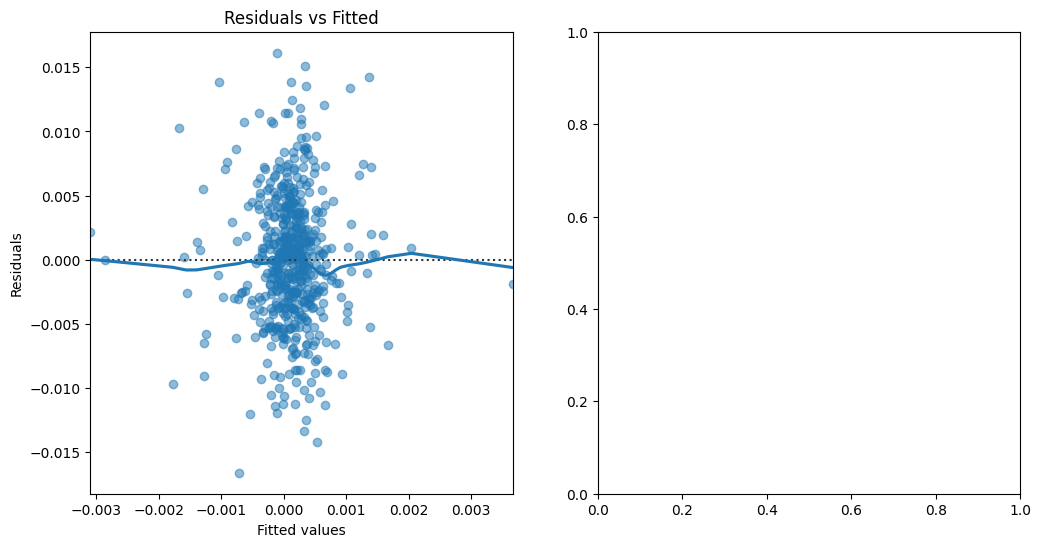

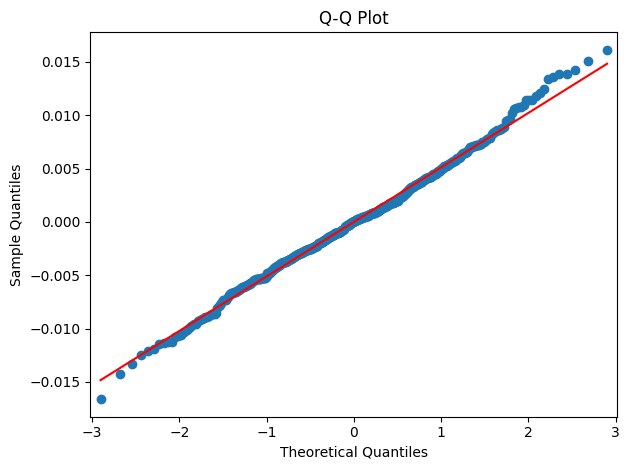

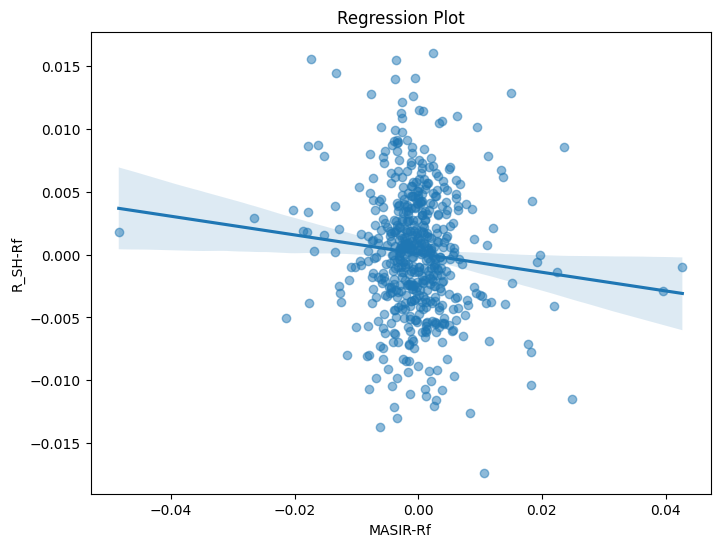

In [ ]:
perform_regression(d_final['MASIR-Rf'],d_final['R_SH-Rf'],d_final['date'],'MASIR-Rf','R_SH-Rf')


                            OLS Regression Results                            
Dep. Variable:                R_BH-Rf   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     42.68
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.19e-10
Time:                        16:18:37   Log-Likelihood:                 2590.9
No. Observations:                 750   AIC:                            -5178.
Df Residuals:                     748   BIC:                            -5169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.793      0.0

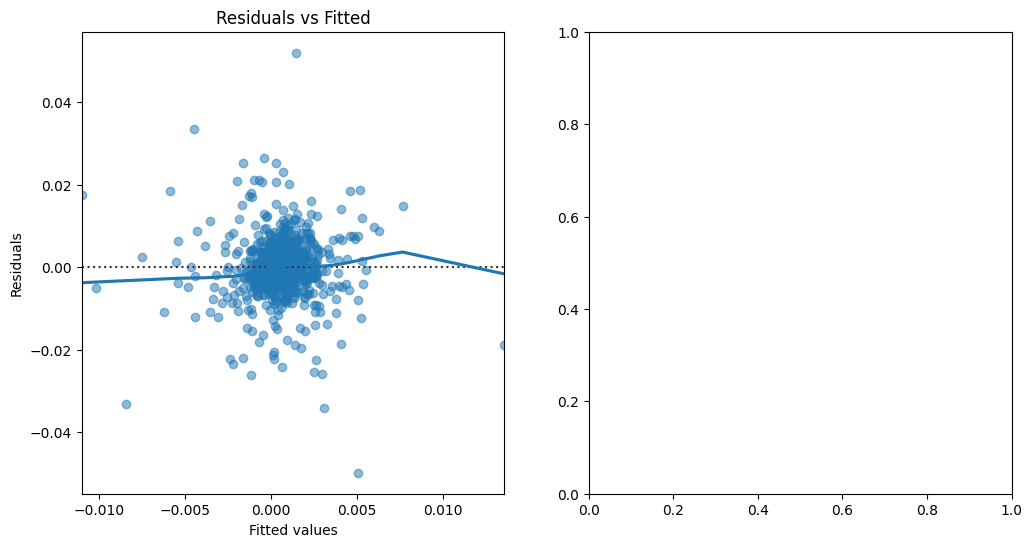

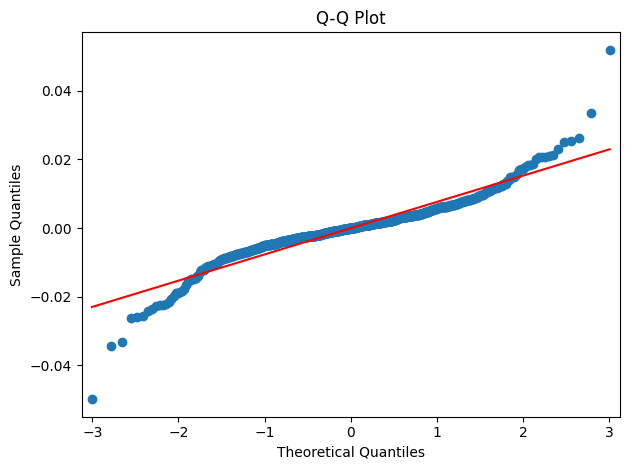

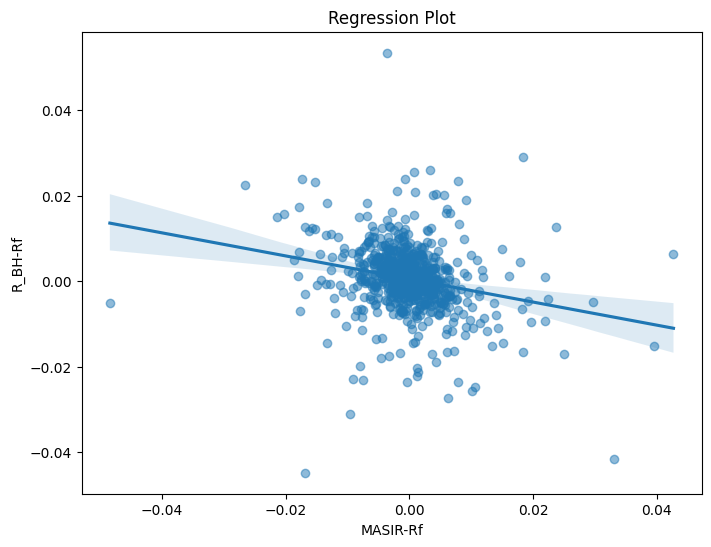

In [ ]:
perform_regression(d_final['MASIR-Rf'],d_final['R_BH-Rf'],d_final['date'],'MASIR-Rf','R_BH-Rf')


                            OLS Regression Results                            
Dep. Variable:                R_SL-Rf   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.48
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           0.000153
Time:                        16:19:02   Log-Likelihood:                 2904.2
No. Observations:                 750   AIC:                            -5804.
Df Residuals:                     748   BIC:                            -5795.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.539e-06      0.000      0.052      0.9

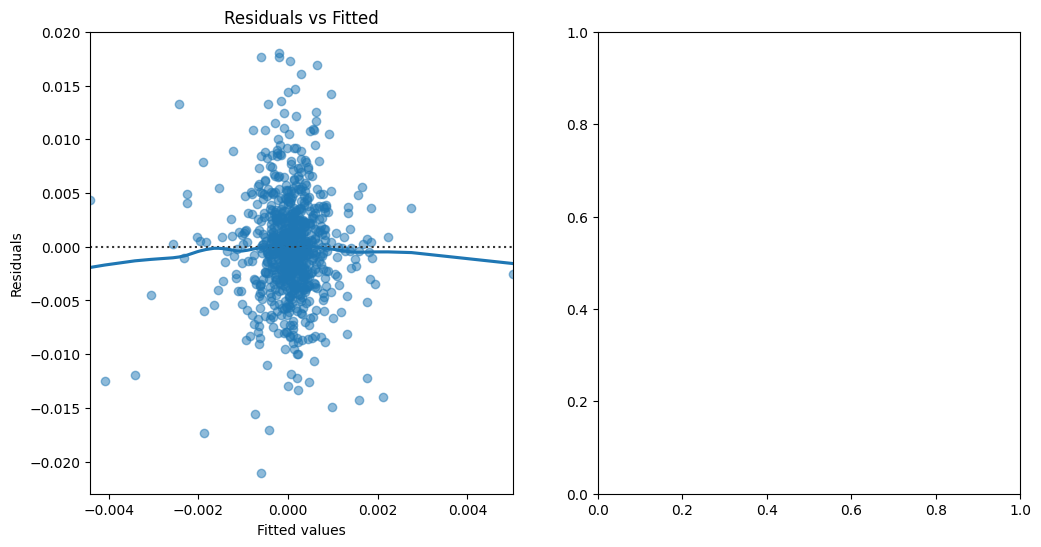

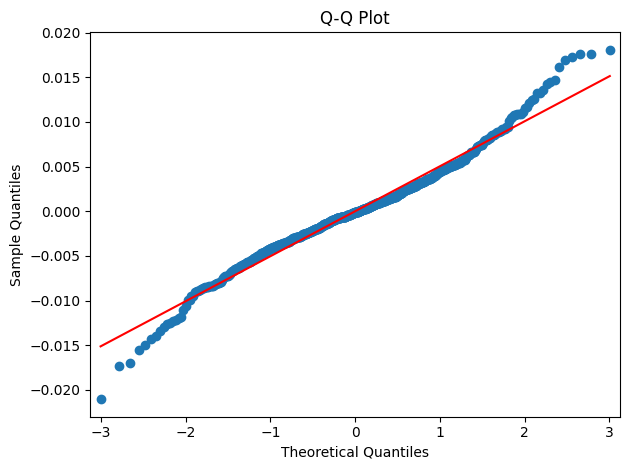

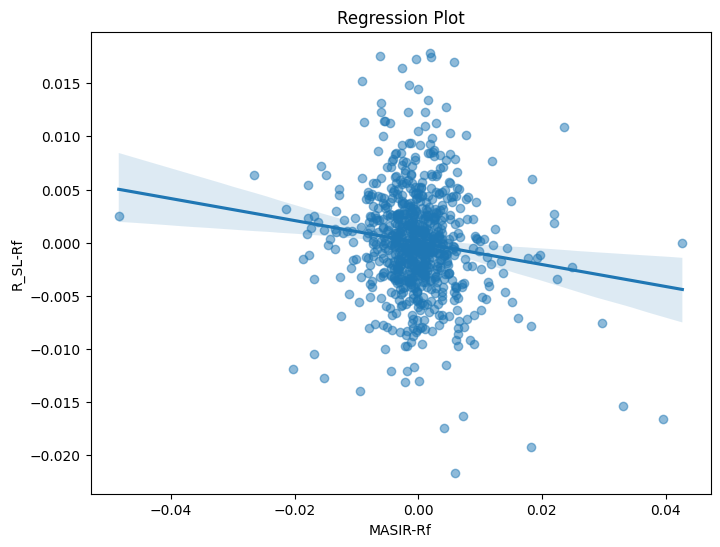

In [ ]:
perform_regression(d_final['MASIR-Rf'],d_final['R_SL-Rf'],d_final['date'],'MASIR-Rf','R_SL-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_BL-Rf   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     33.22
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.49e-08
Time:                        16:19:23   Log-Likelihood:                 1689.0
No. Observations:                 472   AIC:                            -3374.
Df Residuals:                     470   BIC:                            -3366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.431      0.6

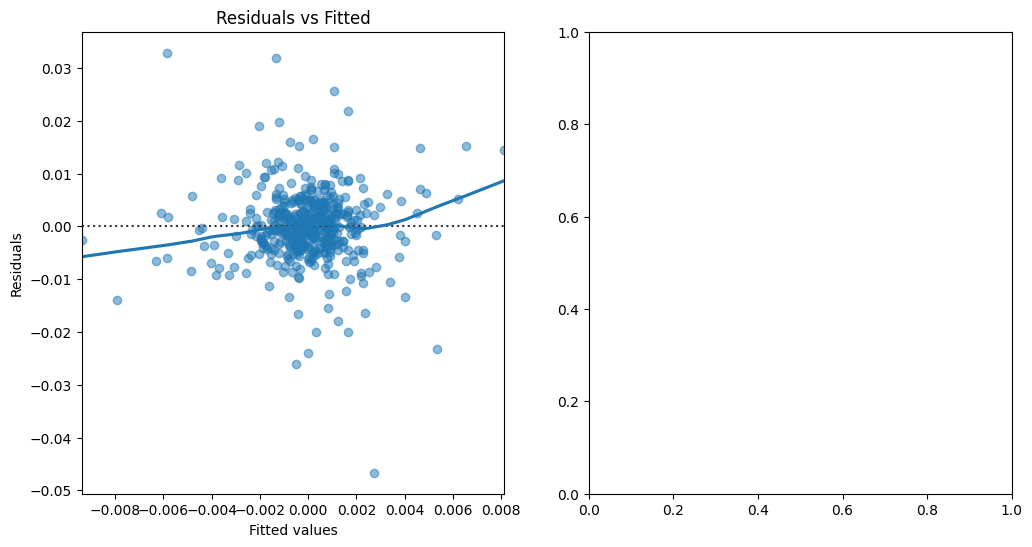

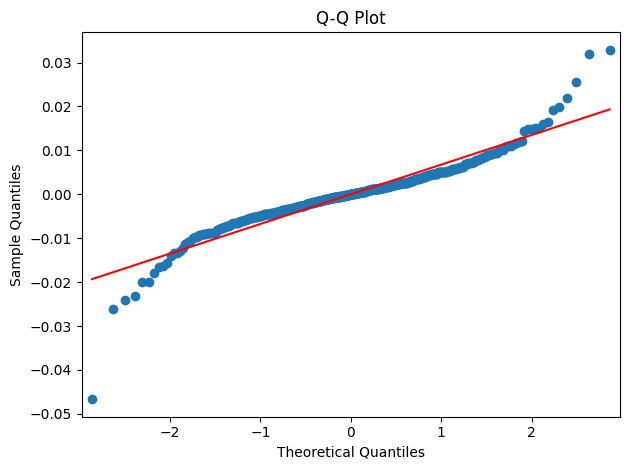

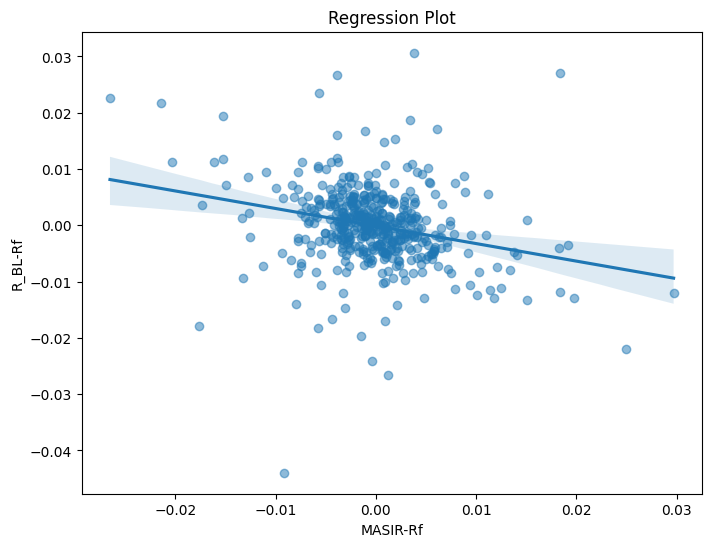

In [ ]:
perform_regression(d_final['MASIR-Rf'],d_final['R_BL-Rf'],d_final['date'],'MASIR-Rf','R_BL-Rf')

# **Par SMB**

                            OLS Regression Results                            
Dep. Variable:                R_SH-Rf   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     20.42
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           8.36e-06
Time:                        16:19:58   Log-Likelihood:                 1455.3
No. Observations:                 377   AIC:                            -2907.
Df Residuals:                     375   BIC:                            -2899.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.114      0.2

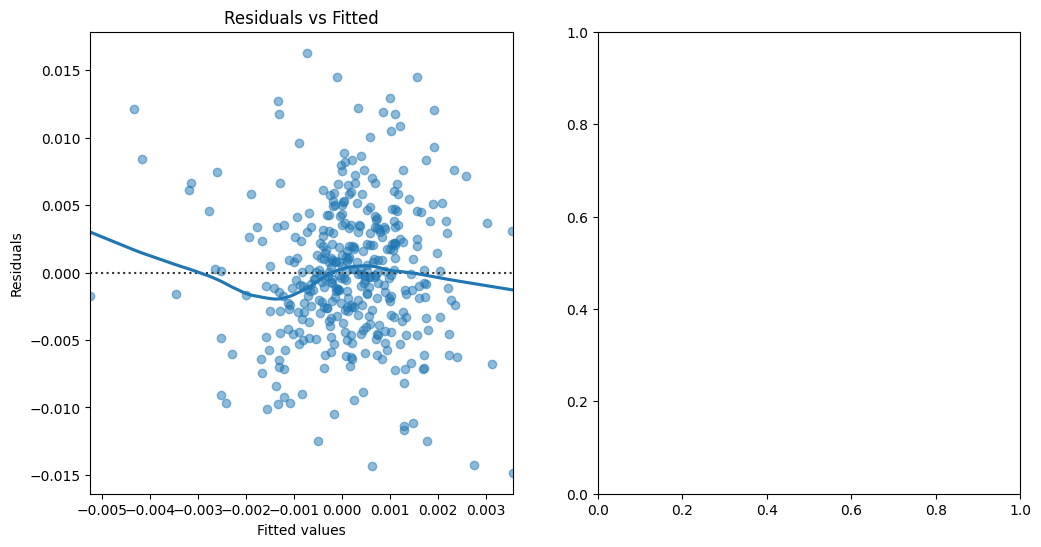

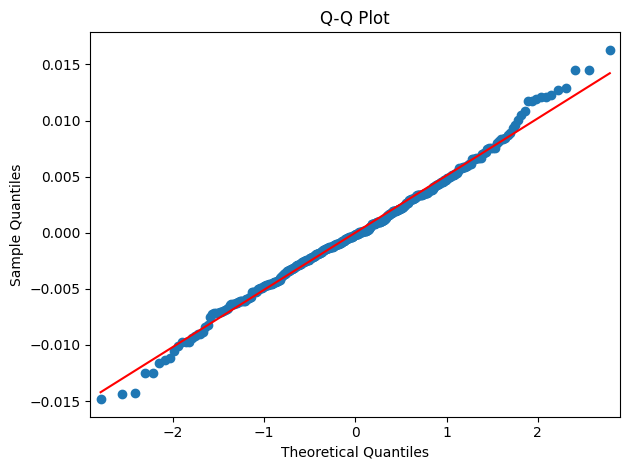

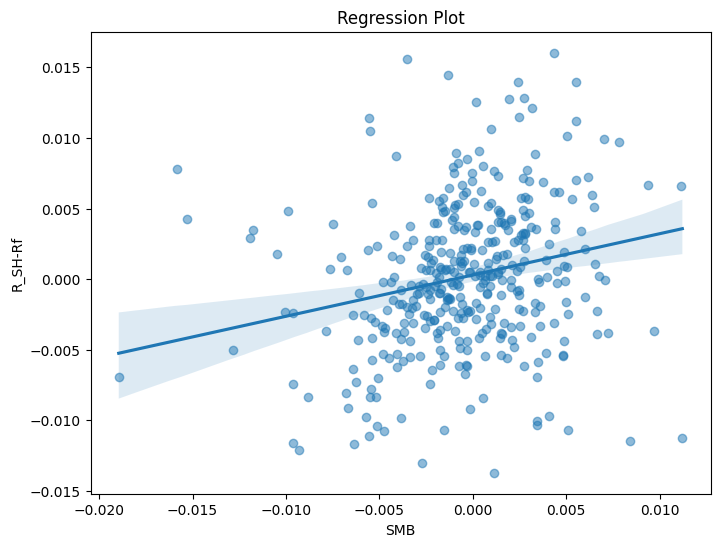

In [ ]:
perform_regression(d_final['SMB'],d_final['R_SH-Rf'],d_final['date'],'SMB','R_SH-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_BH-Rf   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     418.9
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           4.74e-63
Time:                        16:20:22   Log-Likelihood:                 1498.7
No. Observations:                 377   AIC:                            -2993.
Df Residuals:                     375   BIC:                            -2986.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.496      0.1

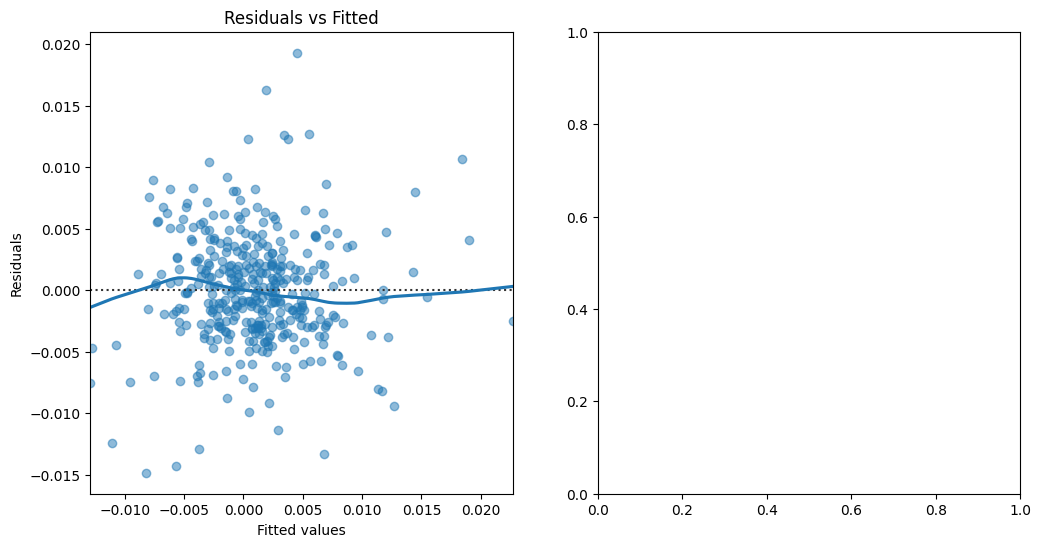

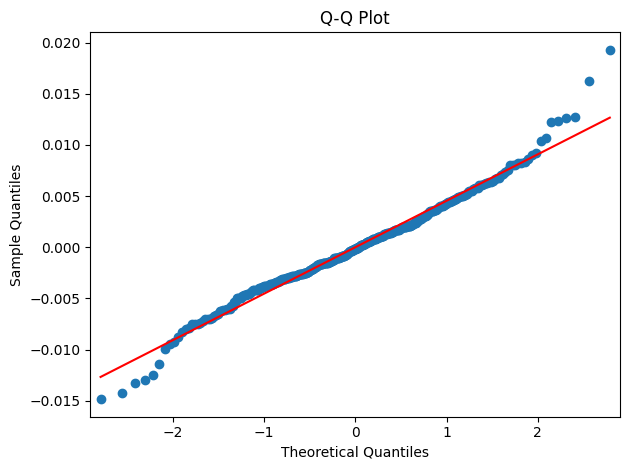

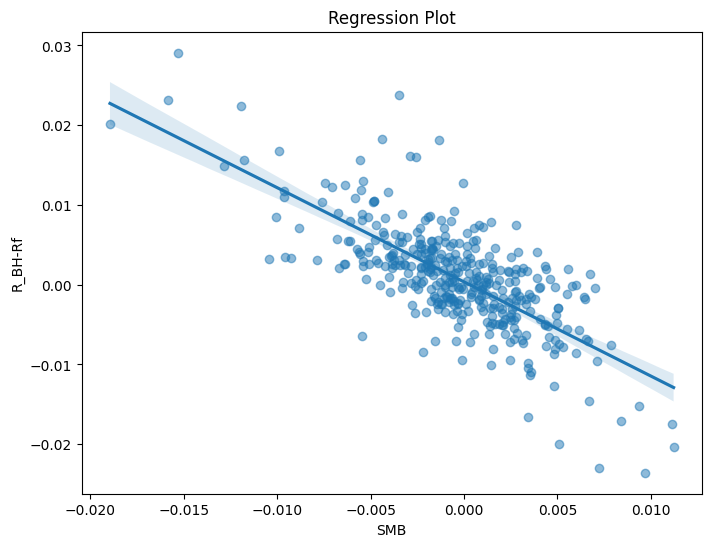

In [ ]:
perform_regression(d_final['SMB'],d_final['R_BH-Rf'],d_final['date'],'SMB','R_BH-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_SL-Rf   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     34.36
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.00e-08
Time:                        16:21:41   Log-Likelihood:                 1456.9
No. Observations:                 377   AIC:                            -2910.
Df Residuals:                     375   BIC:                            -2902.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.313      0.1

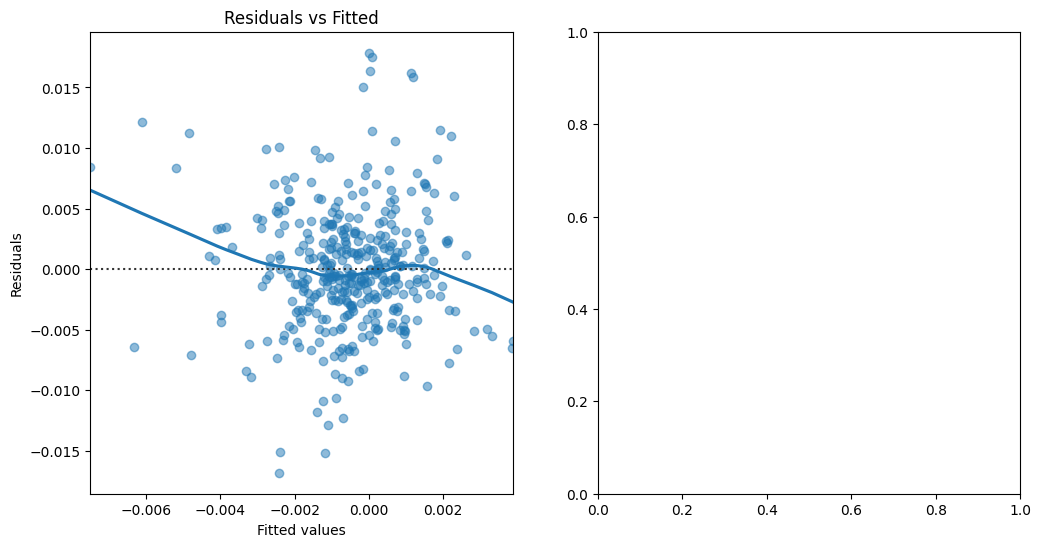

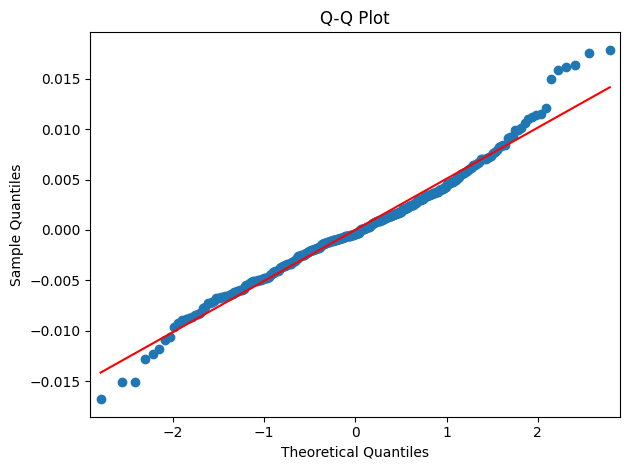

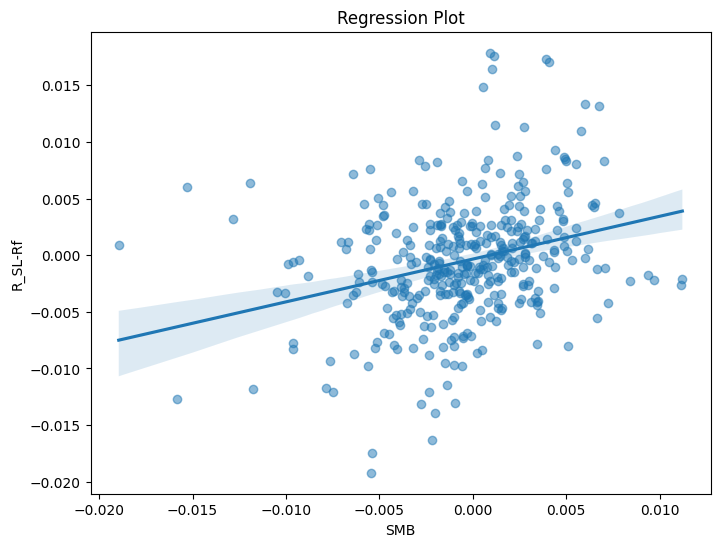

In [ ]:
perform_regression(d_final['SMB'],d_final['R_SL-Rf'],d_final['date'],'SMB','R_SL-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_BL-Rf   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     421.3
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.70e-63
Time:                        16:22:14   Log-Likelihood:                 1509.9
No. Observations:                 377   AIC:                            -3016.
Df Residuals:                     375   BIC:                            -3008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.000     -1.764      0.0

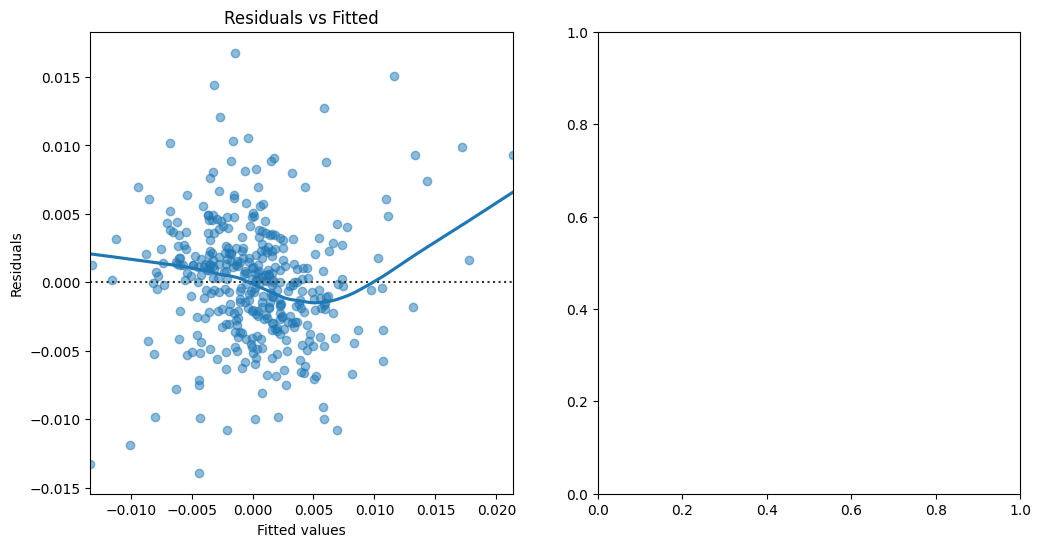

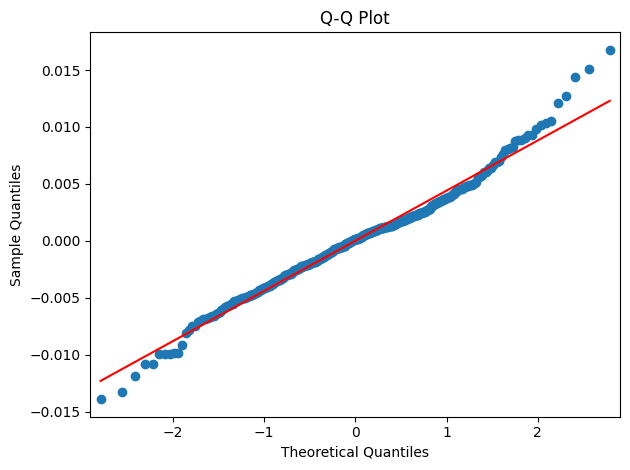

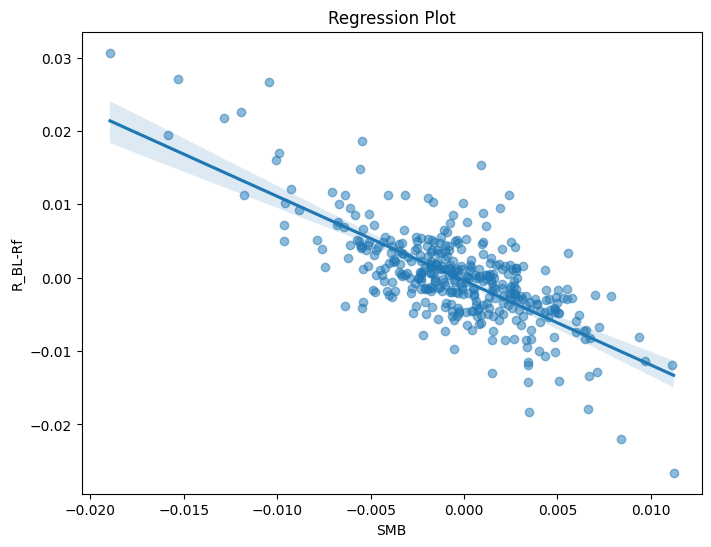

In [ ]:
perform_regression(d_final['SMB'],d_final['R_BL-Rf'],d_final['date'],'SMB','R_BL-Rf')

# **Par HML**

                            OLS Regression Results                            
Dep. Variable:                R_SH-Rf   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     176.0
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           3.35e-33
Time:                        16:23:08   Log-Likelihood:                 1517.9
No. Observations:                 377   AIC:                            -3032.
Df Residuals:                     375   BIC:                            -3024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.342      0.1

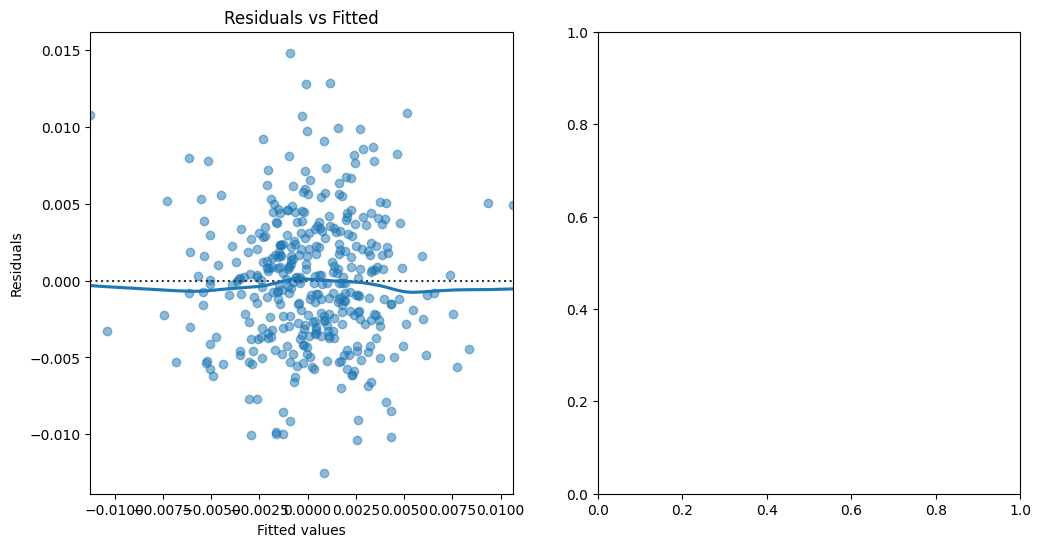

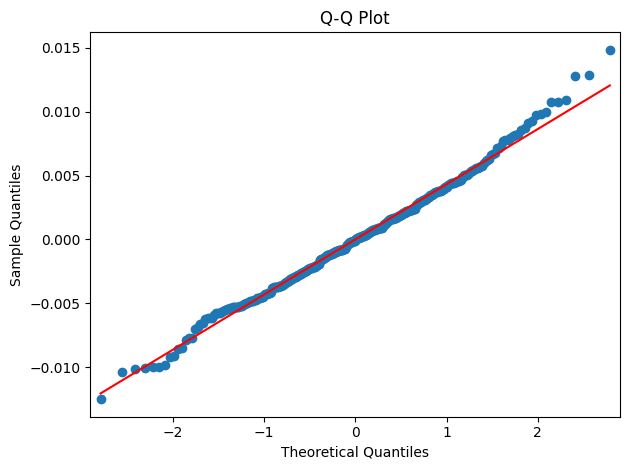

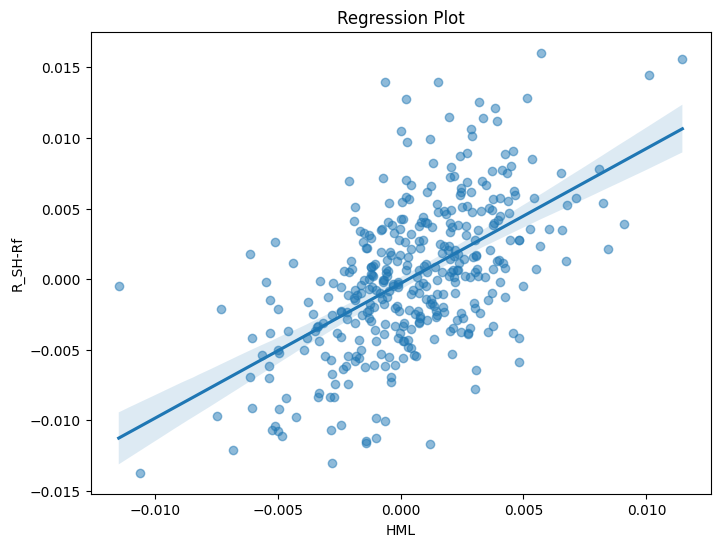

In [ ]:
perform_regression(d_final['HML'],d_final['R_SH-Rf'],d_final['date'],'HML','R_SH-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_BH-Rf   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     38.19
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.68e-09
Time:                        16:23:24   Log-Likelihood:                 1375.6
No. Observations:                 377   AIC:                            -2747.
Df Residuals:                     375   BIC:                            -2739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.777      0.0

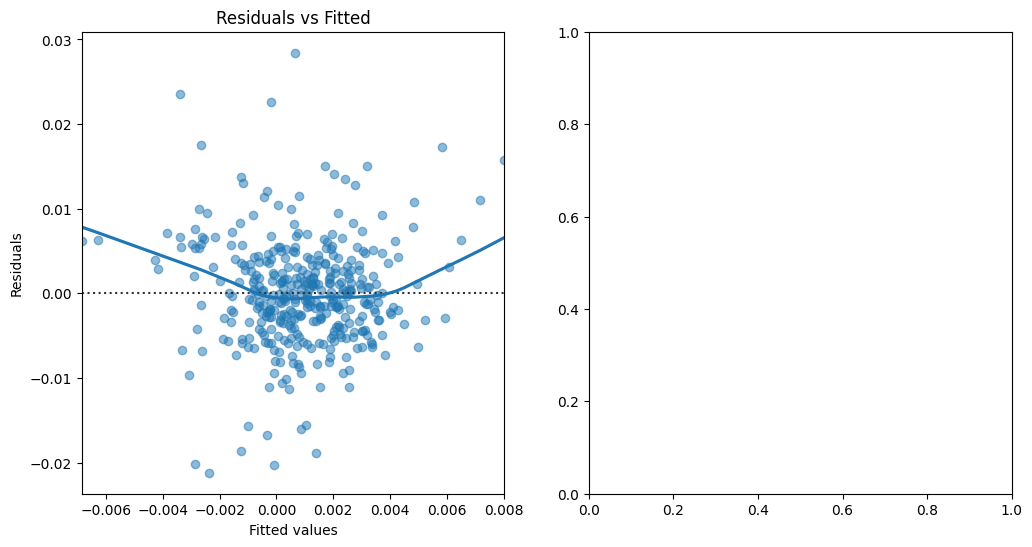

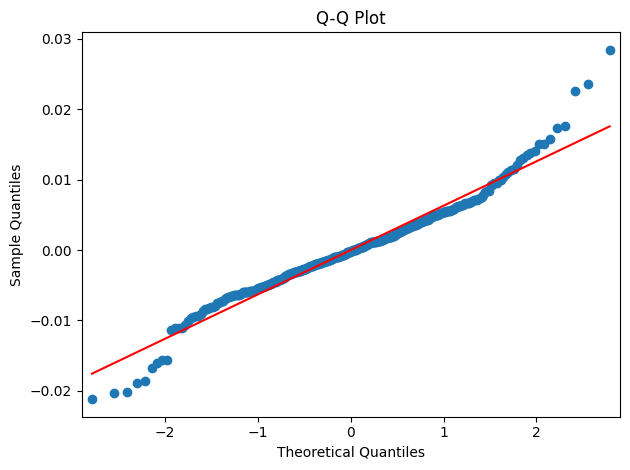

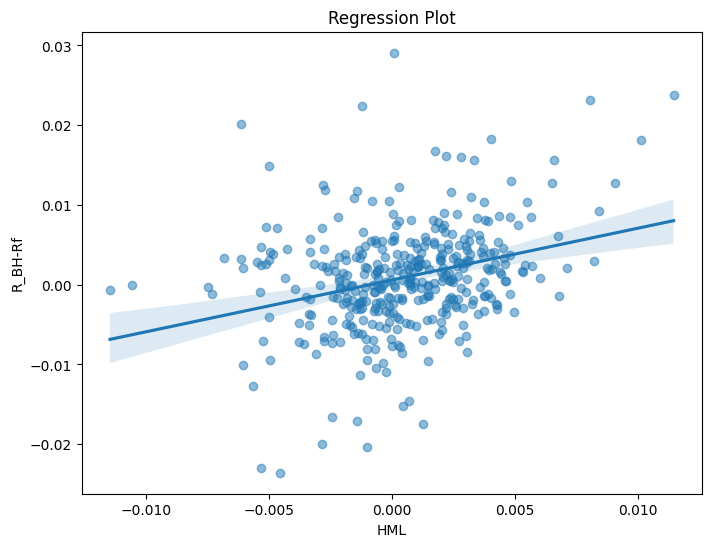

In [ ]:
perform_regression(d_final['HML'],d_final['R_BH-Rf'],d_final['date'],'HML','R_BH-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_SL-Rf   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     167.3
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           6.63e-32
Time:                        16:23:41   Log-Likelihood:                 1509.9
No. Observations:                 377   AIC:                            -3016.
Df Residuals:                     375   BIC:                            -3008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.024e-05      0.000     -0.261      0.7

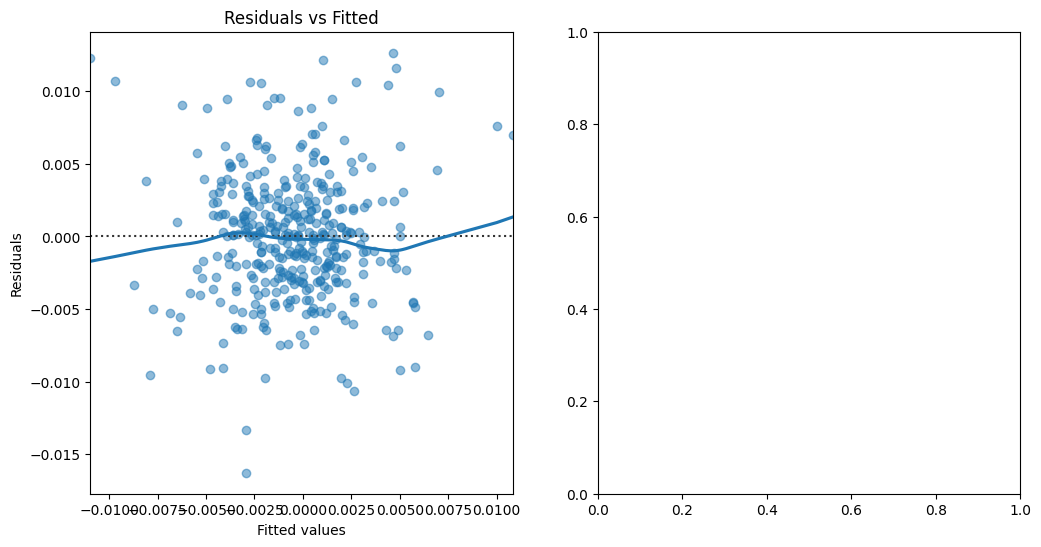

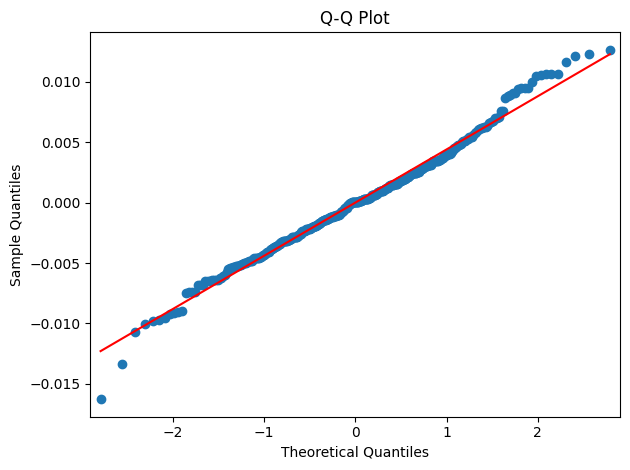

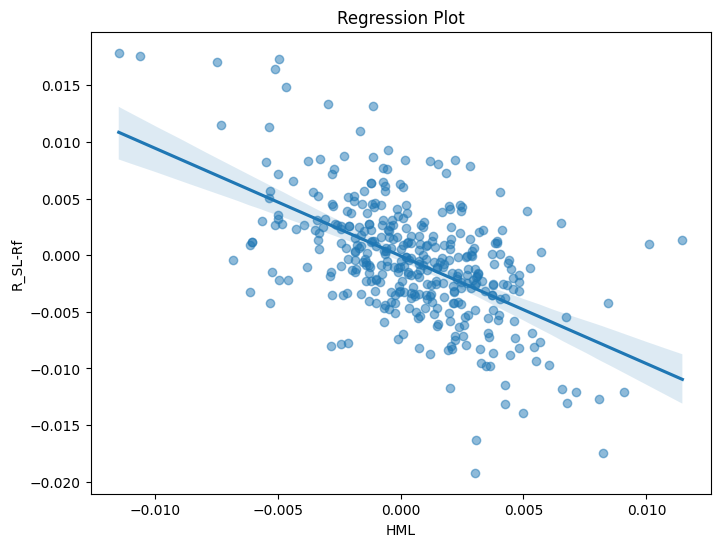

In [ ]:
perform_regression(d_final['HML'],d_final['R_SL-Rf'],d_final['date'],'HML','R_SL-Rf')

                            OLS Regression Results                            
Dep. Variable:                R_BL-Rf   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     17.97
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.83e-05
Time:                        16:23:55   Log-Likelihood:                 1376.7
No. Observations:                 377   AIC:                            -2749.
Df Residuals:                     375   BIC:                            -2742.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.043      0.2

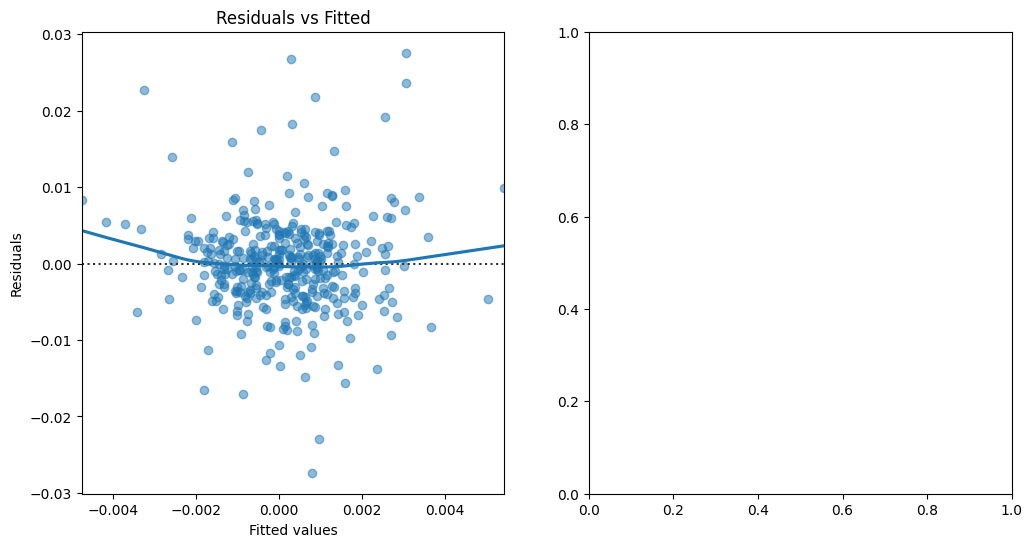

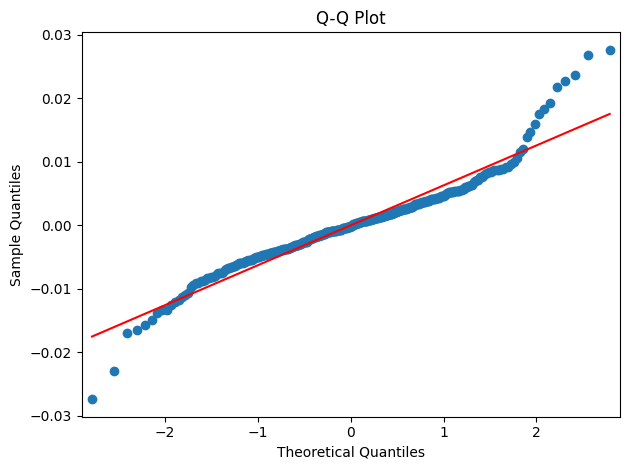

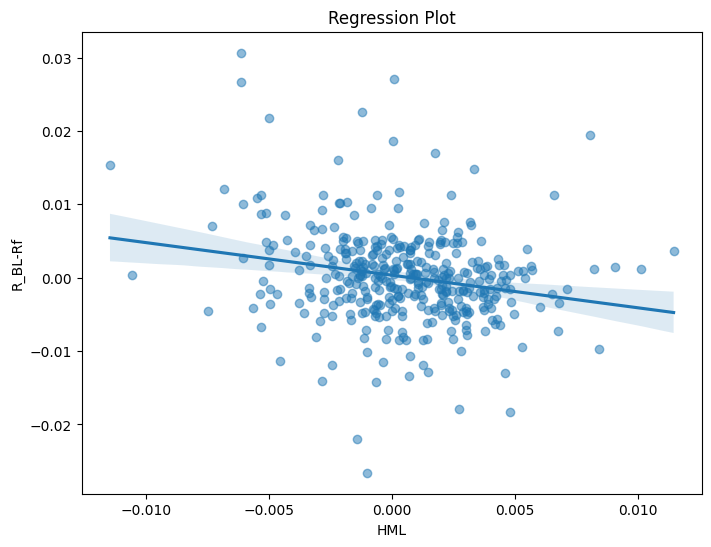

In [ ]:
perform_regression(d_final['HML'],d_final['R_BL-Rf'],d_final['date'],'HML','R_BL-Rf')

# **Par les 3 facteurs**

Nouvelle fonction de régression puisqu'elle est multiple.

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def perform_regression(x, y, date_column, x_labels, y_label):

    df = pd.concat([x, y, date_column], axis=1).dropna()


    x_clean = pd.to_numeric(df[x.columns].stack(), errors='coerce').unstack()
    y_clean = pd.to_numeric(df[y.name], errors='coerce')
    date_clean = df[date_column.name]

    x_clean = sm.add_constant(x_clean)


    model = sm.OLS(y_clean, x_clean).fit()

    print(model.summary())

    plot_residuals(model)
    plot_regression(x_clean, y_clean, x_labels, y_label)

    return model

def plot_residuals(model):

    plt.figure(figsize=(12, 6))

    # Residuals vs Fitted plot
    plt.subplot(1, 2, 1)
    sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, scatter_kws={'alpha': 0.5})
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    sm.qqplot(model.resid, line='s')
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

    plt.tight_layout()
    plt.show()

def plot_regression(x, y, x_labels, y_label):

    num_predictors = x.shape[1] - 1

    plt.figure(figsize=(12, 8))
    for i in range(1, num_predictors + 1):
        plt.subplot(2, num_predictors // 2 + 1, i)
        sns.regplot(x=x.iloc[:, i], y=y, scatter_kws={'alpha': 0.5})
        plt.title(f'Regression Plot: {x_labels[i-1]} vs {y_label}')
        plt.xlabel(x_labels[i-1])
        plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()




                            OLS Regression Results                            
Dep. Variable:                R_SH-Rf   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     86.19
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           2.33e-42
Time:                        16:30:47   Log-Likelihood:                 1542.8
No. Observations:                 376   AIC:                            -3078.
Df Residuals:                     372   BIC:                            -3062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.782      0.4

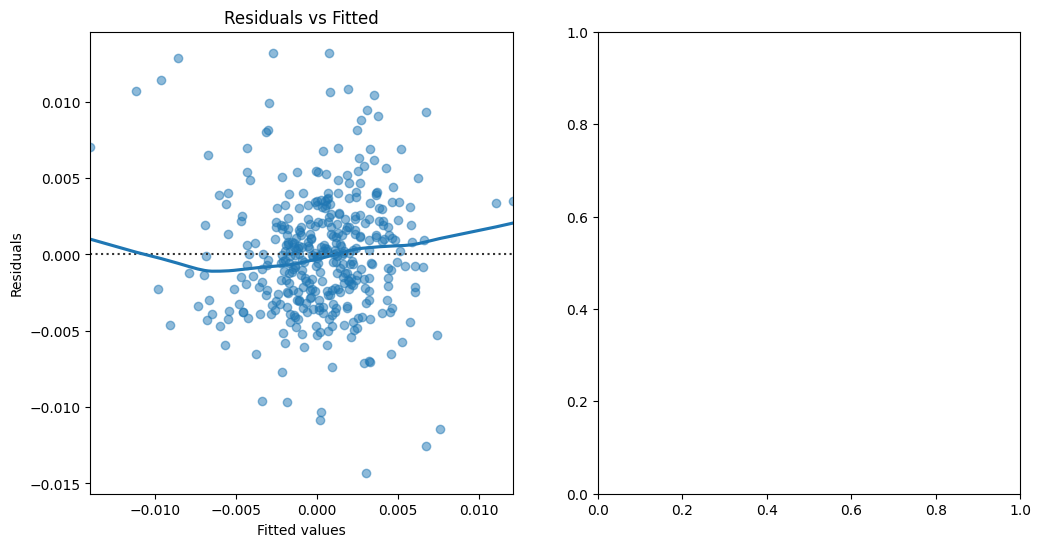

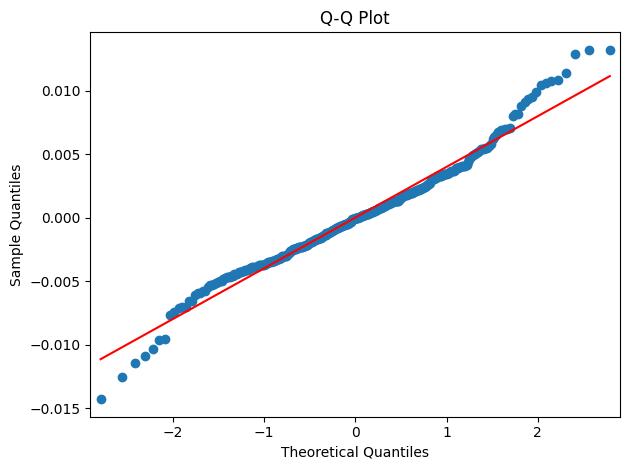

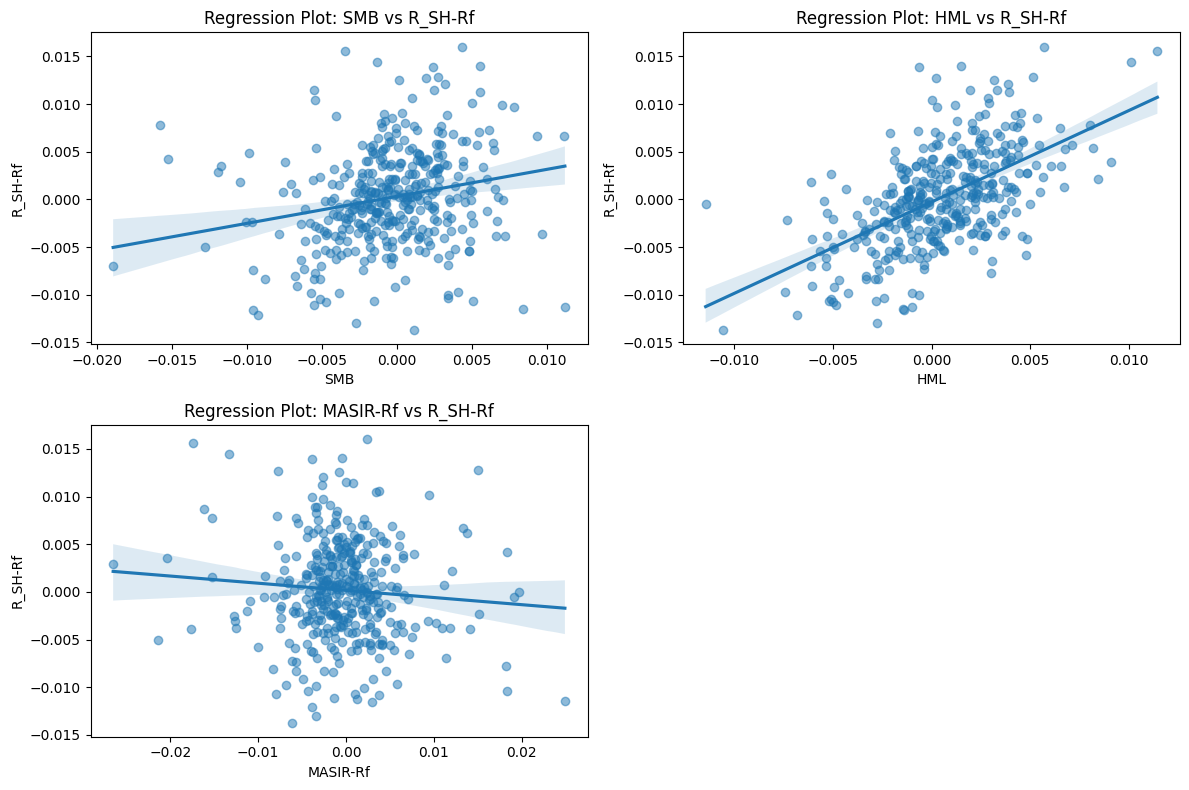

In [ ]:
x = d_final[['SMB', 'HML', 'MASIR-Rf']]
y = d_final['R_SH-Rf']
date_column = d_final['date']
x_labels = ['SMB', 'HML', 'MASIR-Rf']
y_label = 'R_SH-Rf'

perform_regression(x, y, date_column, x_labels, y_label)


                            OLS Regression Results                            
Dep. Variable:                R_BH-Rf   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     211.3
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           5.35e-80
Time:                        16:31:45   Log-Likelihood:                 1540.3
No. Observations:                 376   AIC:                            -3073.
Df Residuals:                     372   BIC:                            -3057.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.905e-05      0.000      0.278      0.7

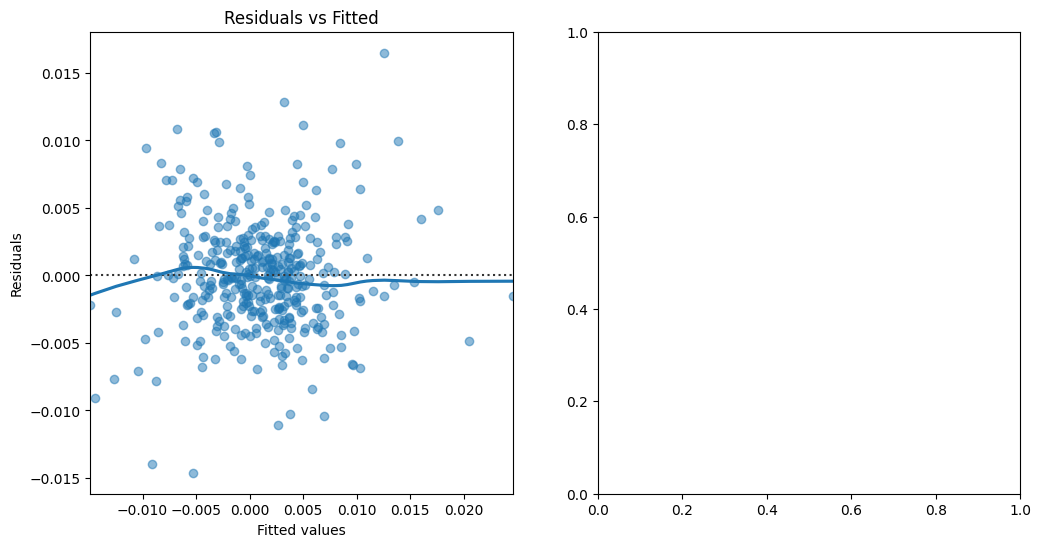

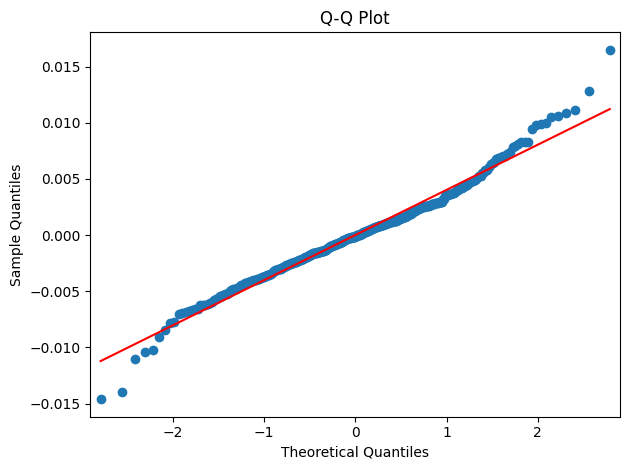

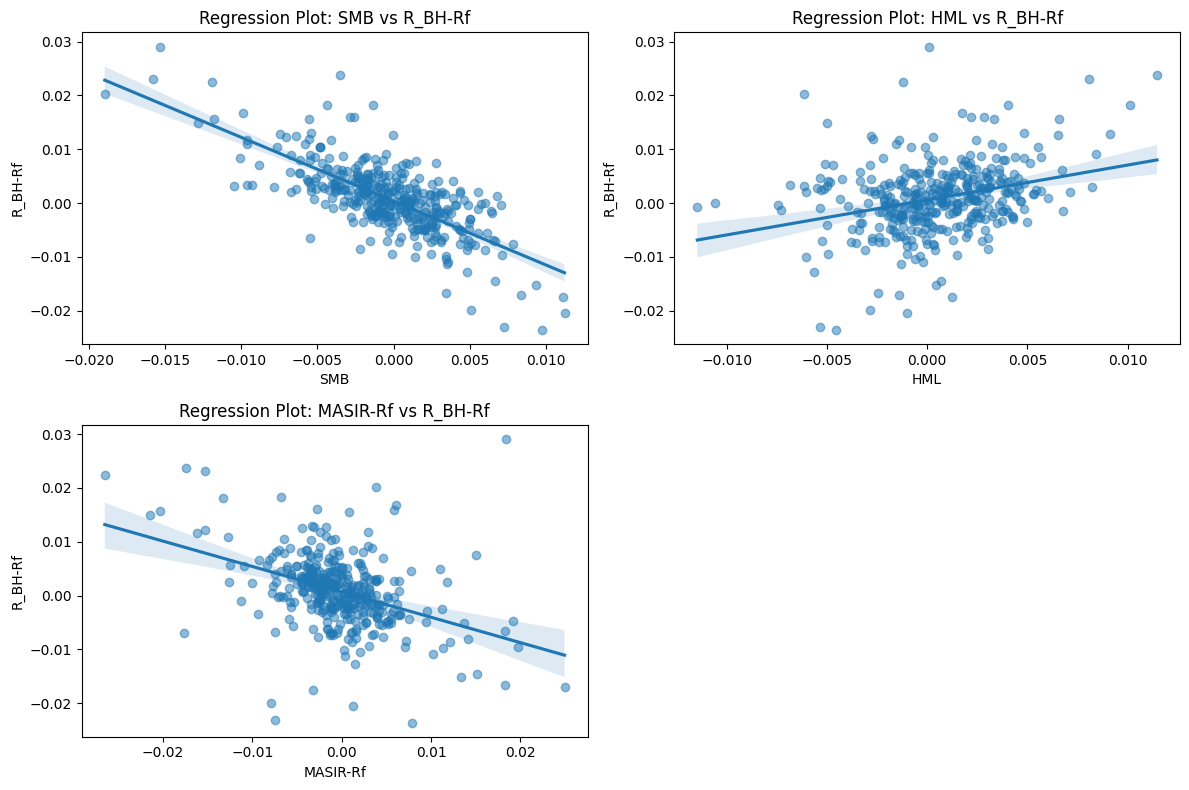

In [ ]:
x = d_final[['SMB', 'HML', 'MASIR-Rf']]
y = d_final['R_BH-Rf']
date_column = d_final['date']
x_labels = ['SMB', 'HML', 'MASIR-Rf']
y_label = 'R_BH-Rf'

perform_regression(x, y, date_column, x_labels, y_label)


                            OLS Regression Results                            
Dep. Variable:                R_SL-Rf   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     90.47
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           5.54e-44
Time:                        16:32:06   Log-Likelihood:                 1540.3
No. Observations:                 376   AIC:                            -3073.
Df Residuals:                     372   BIC:                            -3057.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.905e-05      0.000      0.278      0.7

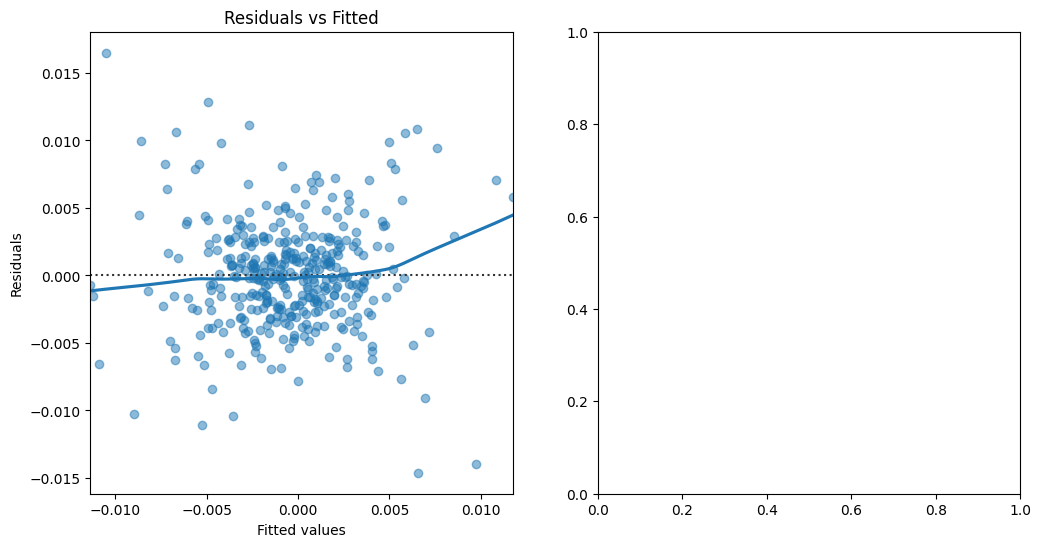

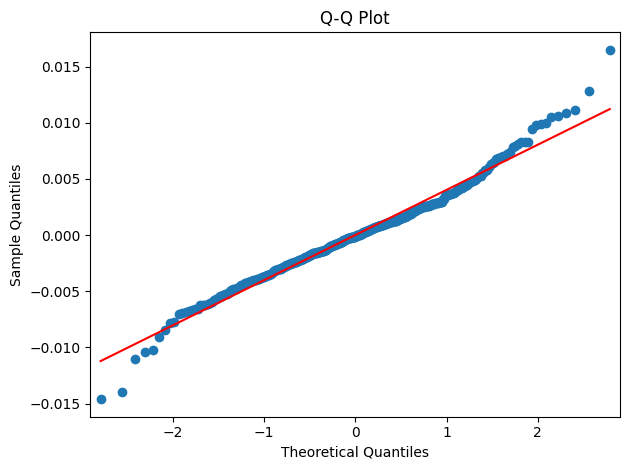

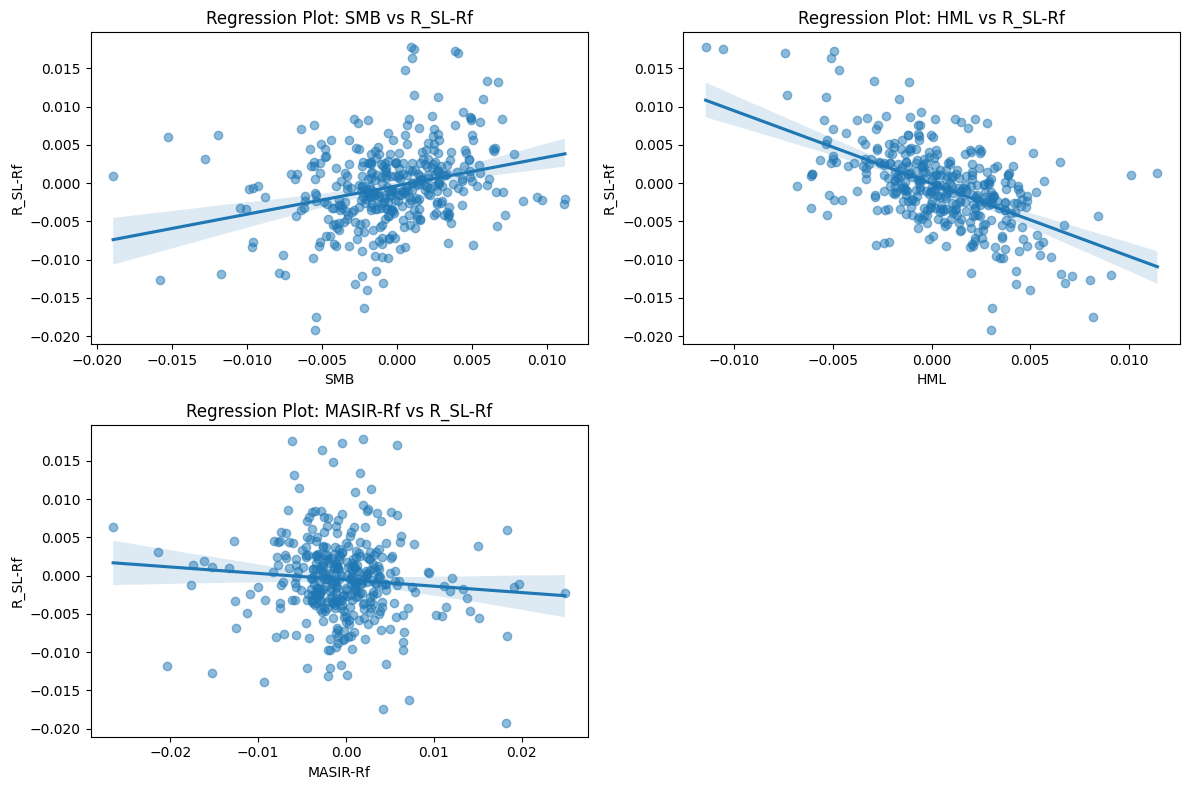

In [ ]:
x = d_final[['SMB', 'HML', 'MASIR-Rf']]
y = d_final['R_SL-Rf']
date_column = d_final['date']
x_labels = ['SMB', 'HML', 'MASIR-Rf']
y_label = 'R_SL-Rf'

perform_regression(x, y, date_column, x_labels, y_label)


                            OLS Regression Results                            
Dep. Variable:                R_BL-Rf   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     196.9
Date:                Sun, 30 Jun 2024   Prob (F-statistic):           1.83e-76
Time:                        16:32:25   Log-Likelihood:                 1542.8
No. Observations:                 376   AIC:                            -3078.
Df Residuals:                     372   BIC:                            -3062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.782      0.4

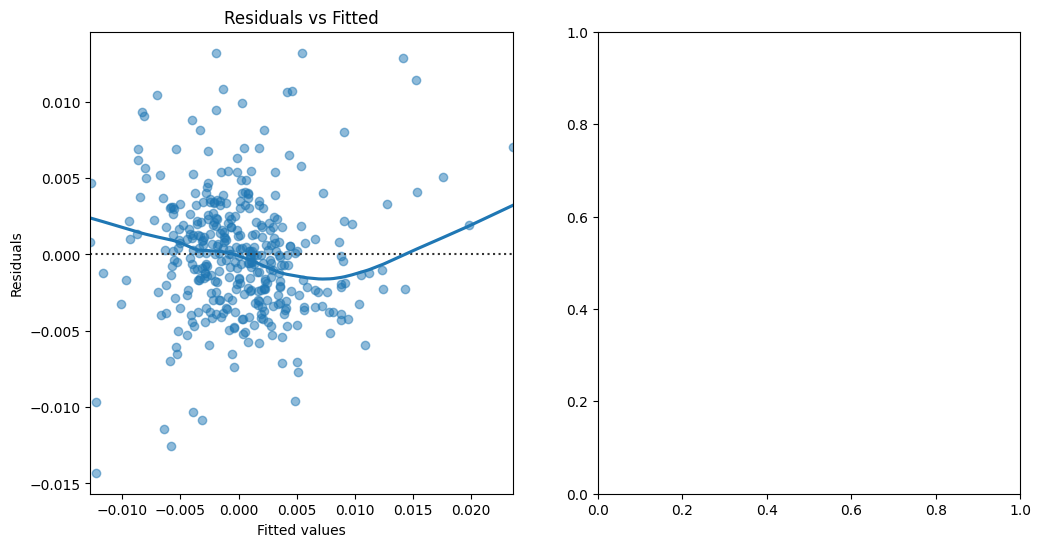

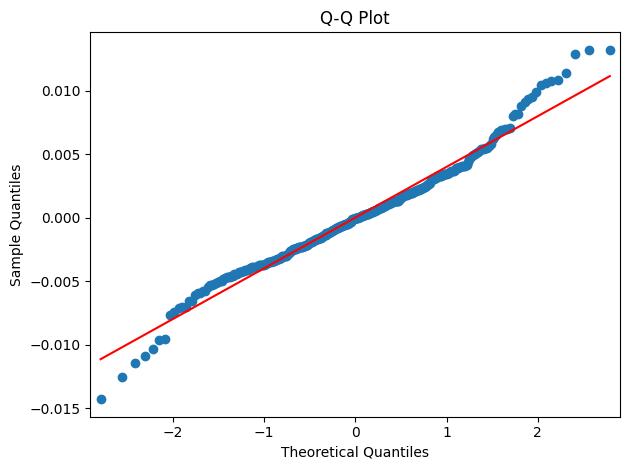

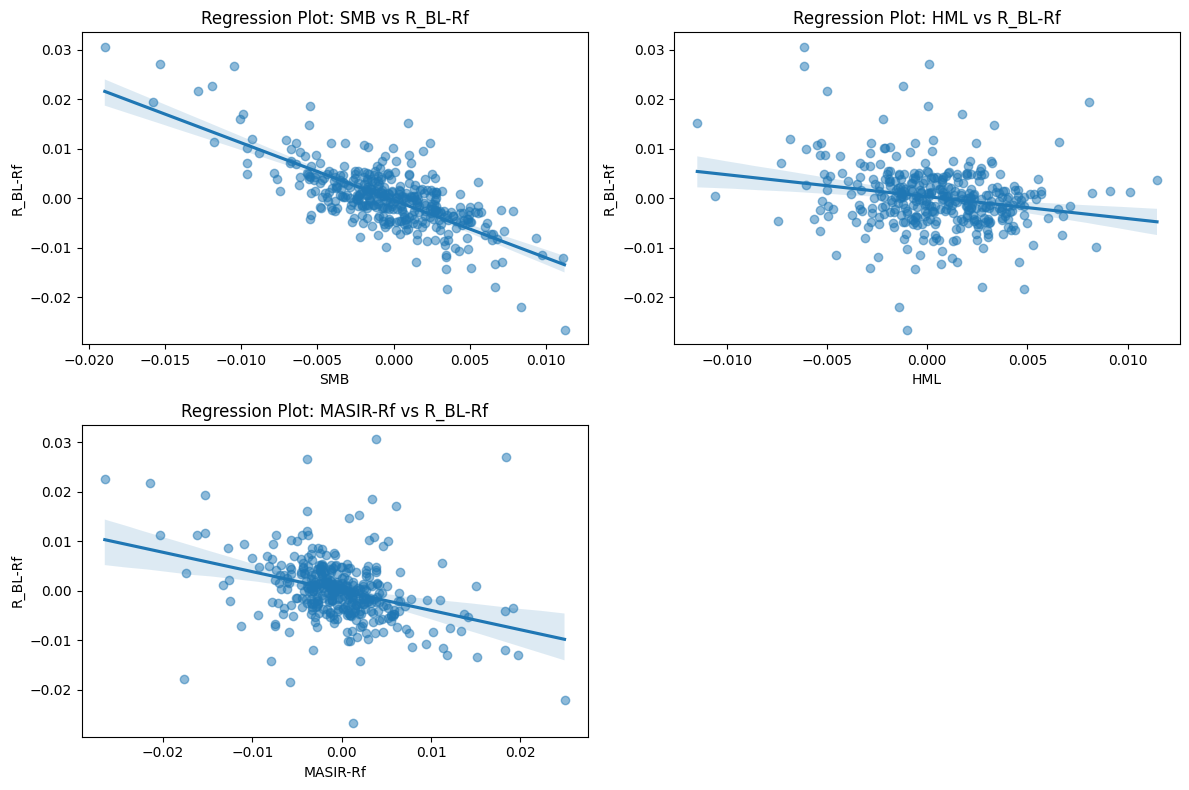

In [ ]:
x = d_final[['SMB', 'HML', 'MASIR-Rf']]
y = d_final['R_BL-Rf']
date_column = d_final['date']
x_labels = ['SMB', 'HML', 'MASIR-Rf']
y_label = 'R_BL-Rf'

perform_regression(x, y, date_column, x_labels, y_label)


# **Tracking-error ex-ante**

Constructing a portfolio containing S (Small) stocks, and assigning weight=0 for B(Big)

In [ ]:
import random

# Randomly sample 5 stocks from each DataFrame
sampled_SH = df_SH.sample(n=5, random_state=1)
sampled_SL = df_SL.sample(n=5, random_state=1)

portfolio_df = pd.concat([sampled_SH, sampled_SL]).reset_index(drop=True)

portfolio_df

libelleFR symbol      codeISIN                   instrument_url  \
0    IMMORENTE INVEST    IMO  MA0000012387  /fr/live-market/instruments/IMO   
1              ENNAKL    NKL  MA0000011942  /fr/live-market/instruments/NKL   
2               SAMIR    SAM  MA0000010803  /fr/live-market/instruments/SAM   
3              DISWAY    DWY  MA0000011637  /fr/live-market/instruments/DWY   
4                SNEP    SNP  MA0000011728  /fr/live-market/instruments/SNP   
5  ALUMINIUM DU MAROC    ALM  MA0000010936  /fr/live-market/instruments/ALM   
6       S.M MONETIQUE    S2M  MA0000012106  /fr/live-market/instruments/S2M   
7            COLORADO    COL  MA0000011934  /fr/live-market/instruments/COL   
8          DIAC SALAF    DIS  MA0000010639  /fr/live-market/instruments/DIS   
9                AGMA    AGM  MA0000010944  /fr/live-market/instruments/AGM   

   drupal_internal__id                          emetteur_url  \
0                  388   /fr/live-market/emetteurs/IMO110518   
1                  381  /fr/live-market/emetteurs/NAKL130710   
2                  492   /fr/live-market/emetteurs/SAM190396   
3                  536   /fr/live-market/emetteurs/MAR280207   
4                  367   /fr/live-market/emetteurs/SNP071107   
5                  490   /fr/live-market/emetteurs/ALM271098   
6                  386   /fr/live-market/emetteurs/S2M271211   
7                  530   /fr/live-market/emetteurs/COL271006   
8                  466   /fr/live-market/emetteurs/DIS010662   
9                  491   /fr/live-market/emetteurs/AGM091198   

                                             Secteur  Capitalisation   PBR  \
0                   Sociétés de placement immobilier    8.340482e+08  1.23   
1                                      Distributeurs    1.056000e+09  1.14   
2                                     Pétrole et Gaz    1.520777e+09  0.41   
3     Matériels, Logiciels et Services Informatiques    1.314376e+09  1.83   
4                                             Chimie    1.223760e+09  1.64   
5              Bâtiment et Matériaux de Construction    7.031246e+08  2.38   
6     Matériels, Logiciels et Services Informatiques    1.436958e+08  2.02   
7              Bâtiment et Matériaux de Construction    8.537499e+08  2.30   
8  Sociétés de financement et Autres Activités Fi...    2.765186e+07   NaN   
9                                         Assurances    1.365000e+09  8.73   

      PER       BTM Category BTM_Category  
0  527,16  0.813008        S            H  
1    6,92  0.877193        S            H  
2       -  2.439024        S            H  
3   18,71  0.546448        S            H  
4       -  0.609756        S            H  
5    0,96  0.420168        S            L  
6    6,78  0.495050        S            L  
7   19,40  0.434783        S            L  
8       -       NaN        S            L  
9   20,16  0.114548        S            L

In [ ]:


dfs_portfolio_S = {}  # Dictionnaire pour stocker les DataFrames

for i in range (0,10):
    df_historique_ = wg_get_history(portfolio_df['drupal_internal__id'][i])
    df_historique_.interpolate(method='linear', inplace=True)  # Interpolation
    dfs_portfolio_S[f"df_historique_{i}"] = df_historique_  # Stocker le DataFrame avec un nom unique

In [ ]:
ids_small=[69,62,101,59,106,6,99,44,56,3]
returns_portfolio_S = pd.DataFrame(columns=['date', 'weighted_return_S'])

# Boucle sur les jours
for j in range(0, 1097):
    S = 0
    total_capitalisation = 0
    date = None

    # Boucle sur les IDs de portefeuille S
    for i in range(0,10):
        df_historique = dfs_portfolio_S[f"df_historique_{i}"]  # Accéder au DataFrame correspondant à l'ID

        # Vérifier si l'index j est dans la plage valide pour ce DataFrame
        if j < len(df_historique['return_daily']):
            d_rt = df_historique['return_daily'][j]  # Récupérer le rendement quotidien pour le jour j
            cap_str = df_historique['capitalisation'][j]  # Récupérer la capitalisation (en chaîne de caractères) pour le jour j

            # Convertir la capitalisation en float
            cap = float(cap_str)

            # Get the date for the day j (assuming all dataframes have the same 'created' dates)
            date = df_historique['created'][j]

            S += d_rt * cap
            total_capitalisation += cap

    if total_capitalisation != 0:
        weighted_return = S / total_capitalisation  # Calculer le rendement pondéré par la capitalisation
    else:
        weighted_return = 0  # Gérer le cas où la capitalisation totale est nulle

    returns_portfolio_S.loc[j] = [date, weighted_return]  # Ajouter la date et le rendement pondéré à la DataFrame returns_SH

returns_portfolio_S

date weighted_return_S
0    2021-06-28               NaT
1    2021-06-29         -0.000524
2    2021-06-30         -0.002098
3    2021-07-01           0.00211
4    2021-07-02         -0.001189
...         ...               ...
1092 2024-06-24          0.000186
1093 2024-06-25         -0.003396
1094 2024-06-26          0.003389
1095 2024-06-27         -0.004015
1096 2024-06-28          0.003112

[1097 rows x 2 columns]

In [ ]:
Rf_quotidien = 3.15 / 100 / 252  # Convertir le rendement annuel en rendement quotidien

# Ajouter la colonne Rf au DataFrame avec la valeur Rf_quotidien pour chaque ligne
returns_portfolio_S['R_f'] = Rf_quotidien

returns_portfolio_S

date weighted_return_S       R_f
0    2021-06-28               NaT  0.000125
1    2021-06-29         -0.000524  0.000125
2    2021-06-30         -0.002098  0.000125
3    2021-07-01           0.00211  0.000125
4    2021-07-02         -0.001189  0.000125
...         ...               ...       ...
1092 2024-06-24          0.000186  0.000125
1093 2024-06-25         -0.003396  0.000125
1094 2024-06-26          0.003389  0.000125
1095 2024-06-27         -0.004015  0.000125
1096 2024-06-28          0.003112  0.000125

[1097 rows x 3 columns]

In [ ]:
returns_portfolio_S['Ri-Rf']= (returns_portfolio_S['weighted_return_S'] - returns_portfolio_S['R_f'])

returns_portfolio_S

date weighted_return_S       R_f     Ri-Rf
0    2021-06-28               NaT  0.000125       NaN
1    2021-06-29         -0.000524  0.000125 -0.000649
2    2021-06-30         -0.002098  0.000125 -0.002223
3    2021-07-01           0.00211  0.000125  0.001985
4    2021-07-02         -0.001189  0.000125 -0.001314
...         ...               ...       ...       ...
1092 2024-06-24          0.000186  0.000125  0.000061
1093 2024-06-25         -0.003396  0.000125 -0.003521
1094 2024-06-26          0.003389  0.000125  0.003264
1095 2024-06-27         -0.004015  0.000125  -0.00414
1096 2024-06-28          0.003112  0.000125  0.002987

[1097 rows x 4 columns]

In [ ]:
returns_portfolio_S=returns_portfolio_S.iloc[1:]
returns_portfolio_S

date weighted_return_S       R_f     Ri-Rf
1    2021-06-29         -0.000524  0.000125 -0.000649
2    2021-06-30         -0.002098  0.000125 -0.002223
3    2021-07-01           0.00211  0.000125  0.001985
4    2021-07-02         -0.001189  0.000125 -0.001314
5    2021-07-03               NaN  0.000125       NaN
...         ...               ...       ...       ...
1092 2024-06-24          0.000186  0.000125  0.000061
1093 2024-06-25         -0.003396  0.000125 -0.003521
1094 2024-06-26          0.003389  0.000125  0.003264
1095 2024-06-27         -0.004015  0.000125  -0.00414
1096 2024-06-28          0.003112  0.000125  0.002987

[1096 rows x 4 columns]

Appliquer Fama-French

                            OLS Regression Results                            
Dep. Variable:                  Ri-Rf   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.479
Date:                Sun, 30 Jun 2024   Prob (F-statistic):              0.221
Time:                        19:02:47   Log-Likelihood:                 935.38
No. Observations:                 252   AIC:                            -1863.
Df Residuals:                     248   BIC:                            -1849.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.179e-05      0.000     -0.185      0.8

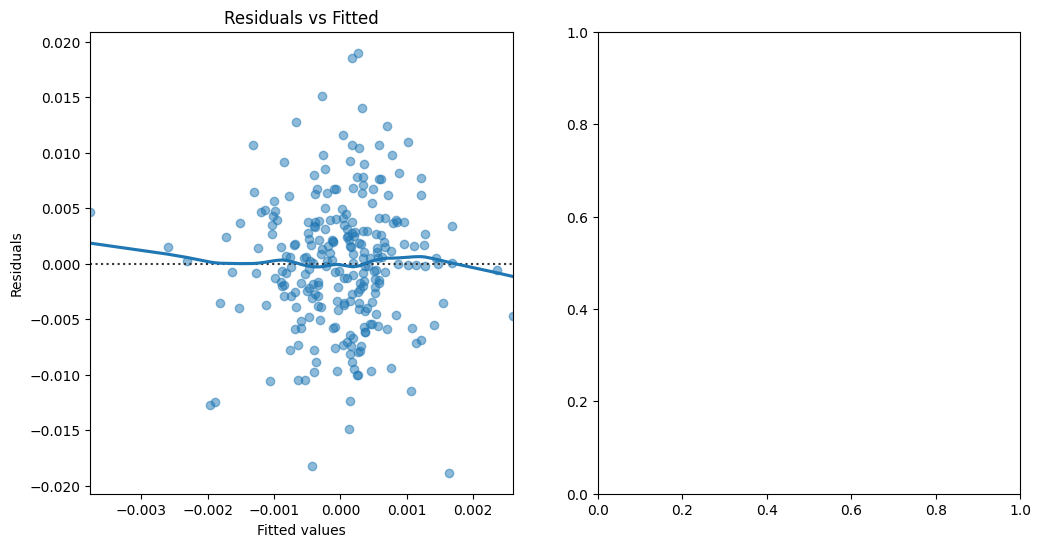

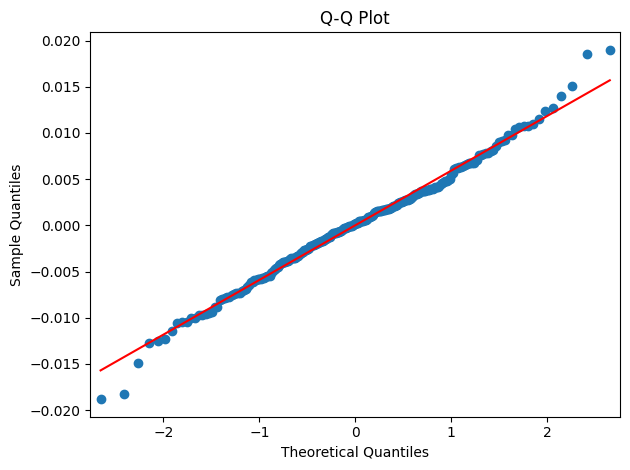

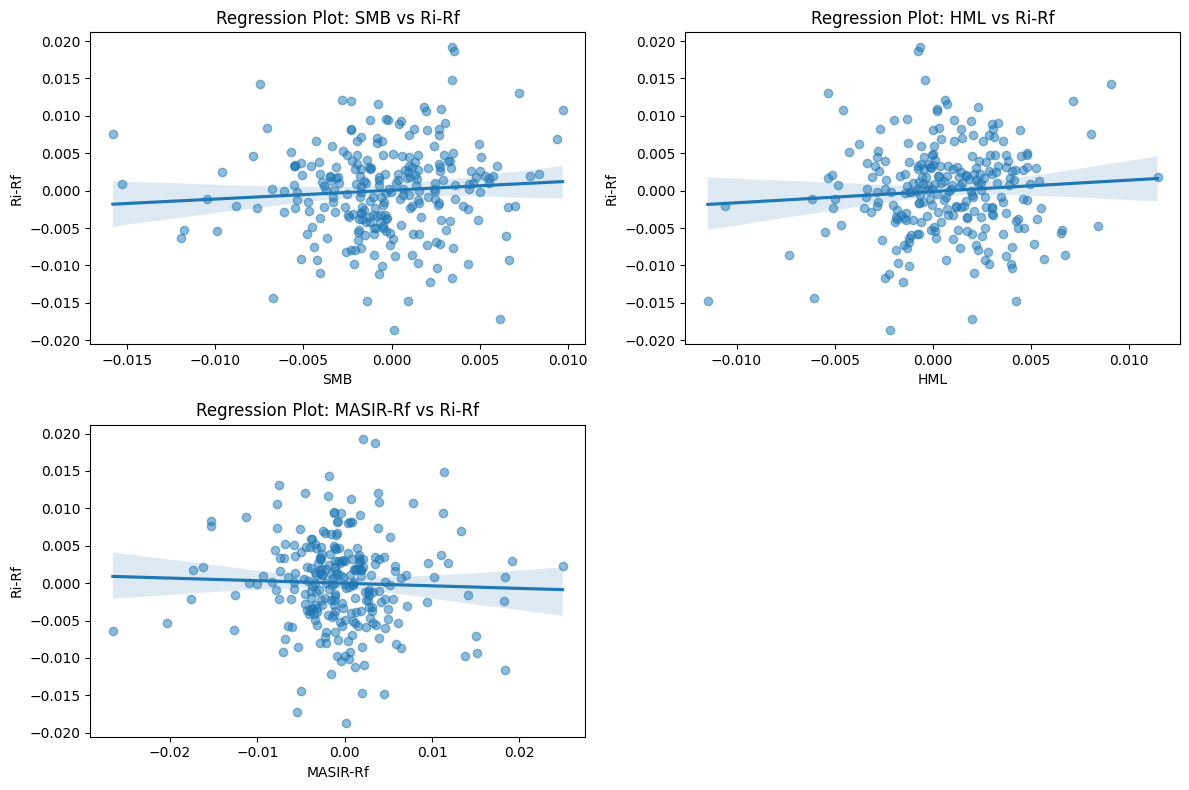

In [ ]:
x = d_final[['SMB', 'HML', 'MASIR-Rf']]
y = returns_portfolio_S['Ri-Rf']
date_column = d_final['date']
x_labels = ['SMB', 'HML', 'MASIR-Rf']
y_label = 'Ri-Rf'

perform_regression(x, y, date_column, x_labels, y_label)

Calculating weights

In [ ]:
import numpy as np
w = np.array([0.1681/(0.1681+0.1669+0.0631), 0.1669/(0.1681+0.1669+0.0631), 0.0631/(0.1681+0.1669+0.0631)])
w

array([0.42225571, 0.4192414 , 0.15850289])

In [ ]:
factors = d_final[['HML', 'SMB', 'MASIR-Rf']]
factors = factors.apply(pd.to_numeric, errors='coerce')
factors = factors.dropna()
cov_matrix = factors.cov()

cov_matrix

HML           SMB      MASIR-Rf
HML       9.632313e-06 -6.349924e-07 -8.030231e-07
SMB      -6.349924e-07  1.653509e-05  7.858923e-06
MASIR-Rf -8.030231e-07  7.858923e-06  3.351117e-05

In [ ]:
cov_matrix = np.array([[9.632313e-06, -6.349924e-07, -8.030231e-07],
                       [-6.349924e-07, 1.653509e-05, 7.858923e-06],
                       [	-8.030231e-07, 7.858923e-06	, 3.351117e-05]])

In [ ]:
w = np.array([ 0.4192414 , 0.42225571, 0.15850289])
tracking_error = np.sqrt(np.dot(np.dot(w, cov_matrix), w.T))
tracking_error

0.0024906926163459787